# Inspect the single-lineage model run on the prostate data (006)

 Model attributes:

- sgRNA | gene varying intercept
- RNA and CN varying effects per gene
- correlation between gene varying effects modeled using the multivariate normal and Cholesky decomposition (non-centered parameterization)
- target gene mutation variable and cancer gene comutation variable.
- varying effect for cell line

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel
from speclet.data_processing.common import head_tail
from speclet.io import modeling_data_dir, models_dir
from speclet.managers.data_managers import CrisprScreenDataManager, broad_only
from speclet.plot import set_speclet_theme
from speclet.project_configuration import arviz_config

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"
arviz_config()

## Data

In [5]:
saved_model_dir = models_dir() / "hnb-single-lineage-prostate-006_PYMC_NUMPYRO"

In [6]:
with open(saved_model_dir / "description.txt") as f:
    model_description = "".join(list(f))

print(model_description)

name: 'hnb-single-lineage-prostate-006'
fit method: 'PYMC_NUMPYRO'

--------------------------------------------------------------------------------

CONFIGURATION

{
    "name": "hnb-single-lineage-prostate-006",
    "description": " Single lineage hierarchical negative binomial model for prostate data from the Broad. Added a variable for cell line varying effect. (Skipped 005.) ",
    "active": true,
    "model": "LINEAGE_HIERARCHICAL_NB",
    "data_file": "modeling_data/lineage-modeling-data/depmap-modeling-data_prostate.csv",
    "model_kwargs": {
        "lineage": "prostate"
    },
    "sampling_kwargs": {
        "pymc_mcmc": null,
        "pymc_advi": null,
        "pymc_numpyro": {
            "draws": 1000,
            "tune": 1000,
            "chains": 4,
            "target_accept": 0.98,
            "progress_bar": true,
            "chain_method": "parallel",
            "postprocessing_backend": "cpu",
            "idata_kwargs": {
                "log_likelihood": fals

### Load posterior summary

In [7]:
prostate_post_summary = pd.read_csv(saved_model_dir / "posterior-summary.csv").assign(
    var_name=lambda d: [x.split("[")[0] for x in d["parameter"]]
)
prostate_post_summary.head()

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
0   mu_mu_a  0.079  0.029     0.048      0.119      0.012    0.009       8.0   
1      mu_b  0.003  0.002     0.000      0.004      0.001    0.001       7.0   
2      mu_d -0.020  0.002    -0.021     -0.018      0.001    0.001       7.0   
3   sigma_a  0.159  0.092     0.000      0.213      0.046    0.035       7.0   
4   sigma_k  0.029  0.025     0.000      0.054      0.008    0.006       7.0   

   ess_tail  r_hat var_name  
0    1549.0   1.44  mu_mu_a  
1       4.0   1.53     mu_b  
2    2911.0   1.52     mu_d  
3       4.0   1.53  sigma_a  
4       4.0   1.53  sigma_k

### Load trace object

In [8]:
trace_file = saved_model_dir / "posterior.netcdf"
assert trace_file.exists()
trace = az.from_netcdf(trace_file)

### Prostate data

In [9]:
prostate_dm = CrisprScreenDataManager(
    modeling_data_dir() / "lineage-modeling-data" / "depmap-modeling-data_prostate.csv",
    transformations=[broad_only],
)

In [10]:
prostate_data = prostate_dm.get_data(read_kwargs={"low_memory": False})
prostate_data.head()

sgrna                 replicate_id       lfc p_dna_batch  \
0  AAAGCCCAGGAGTATGGGAG  Vcap-304Cas9_RepA_p4_batch3  0.246450           3   
1  AAATCAGAGAAACCTGAACG  Vcap-304Cas9_RepA_p4_batch3  0.626518           3   
2  AACGTCTTTGAAGAAAGCTG  Vcap-304Cas9_RepA_p4_batch3  0.165114           3   
3  AACGTCTTTGAAGGAAGCTG  Vcap-304Cas9_RepA_p4_batch3 -0.094688           3   
4  AAGAGGTTCCAGACTACTTA  Vcap-304Cas9_RepA_p4_batch3  0.294496           3   

   genome_alignment hugo_symbol screen  multiple_hits_on_gene  \
0  chr2_130522105_-       CFC1B  broad                   True   
1  chr11_89916950_-    TRIM49D1  broad                   True   
2   chr5_71055421_-      GTF2H2  broad                   True   
3   chr5_69572480_+     GTF2H2C  broad                   True   
4  chrX_155898173_+       VAMP7  broad                   True   

  sgrna_target_chr  sgrna_target_pos  ... any_deleterious  any_tcga_hotspot  \
0                2         130522105  ...             NaN               NaN   
1               11          89916950  ...             NaN               NaN   
2                5          71055421  ...             NaN               NaN   
3                5          69572480  ...             NaN               NaN   
4                X         155898173  ...             NaN               NaN   

   any_cosmic_hotspot  is_mutated  copy_number   lineage  \
0                 NaN       False     0.999455  prostate   
1                 NaN       False     1.281907  prostate   
2                 NaN       False     0.616885  prostate   
3                 NaN       False     0.616885  prostate   
4                 NaN       False     0.615935  prostate   

           lineage_subtype primary_or_metastasis  is_male   age  
0  prostate_adenocarcinoma            metastasis     True  59.0  
1  prostate_adenocarcinoma            metastasis     True  59.0  
2  prostate_adenocarcinoma            metastasis     True  59.0  
3  prostate_adenocarcinoma            metastasis     True  59.0  
4  prostate_adenocarcinoma            metastasis     True  59.0  

[5 rows x 25 columns]

### Single lineage model

In [11]:
prostate_model = LineageHierNegBinomModel(lineage="prostate")

In [12]:
valid_prostate_data = prostate_model.data_processing_pipeline(prostate_data.copy())
prostate_mdl_data = prostate_model.make_data_structure(valid_prostate_data)

[INFO] 2022-08-03 13:24:20 [(lineage_hierarchical_nb.py:data_processing_pipeline:274] Processing data for modeling.
[INFO] 2022-08-03 13:24:20 [(lineage_hierarchical_nb.py:data_processing_pipeline:275] LFC limits: (-5.0, 5.0)
[WARNING] 2022-08-03 13:25:23 [(lineage_hierarchical_nb.py:data_processing_pipeline:326] number of data points dropped: 2
[INFO] 2022-08-03 13:25:23 [(lineage_hierarchical_nb.py:target_gene_is_mutated_vector:503] number of genes mutated in all cells lines: 0
[DEBUG] 2022-08-03 13:25:23 [(lineage_hierarchical_nb.py:target_gene_is_mutated_vector:506] Genes always mutated: 
[INFO] 2022-08-03 13:25:23 [(lineage_hierarchical_nb.py:_trim_cancer_genes:559] Dropping 8 cancer genes.
[DEBUG] 2022-08-03 13:25:23 [(lineage_hierarchical_nb.py:_trim_cancer_genes:560] Dropped cancer genes: ['AR', 'AXIN1', 'FOXA1', 'KLF6', 'NCOR2', 'PTEN', 'SALL4', 'SPOP']


## Analysis

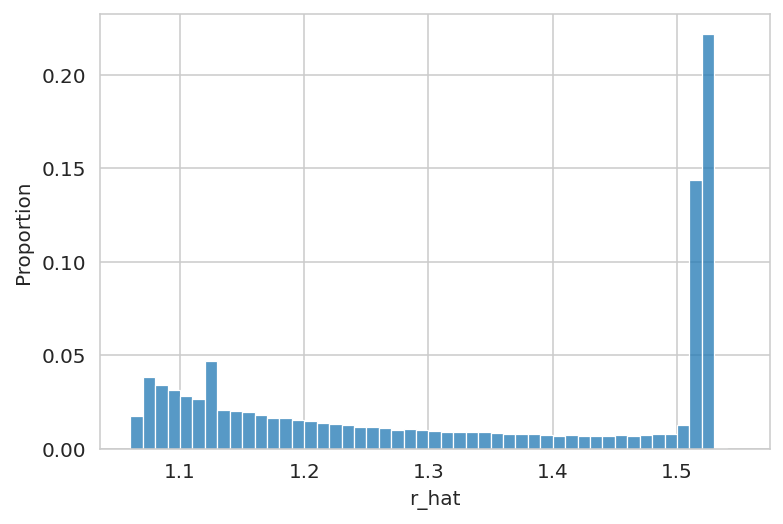

In [13]:
sns.histplot(x=prostate_post_summary["r_hat"], binwidth=0.01, stat="proportion");

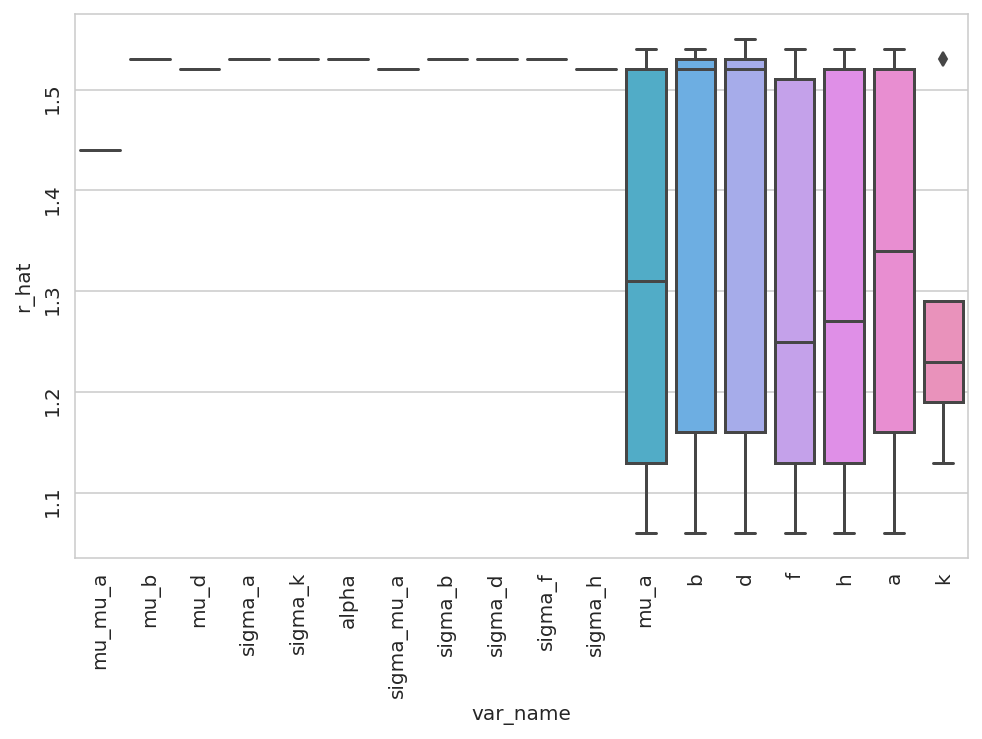

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=prostate_post_summary, x="var_name", y="r_hat", ax=ax)
ax.tick_params(rotation=90)
plt.show()

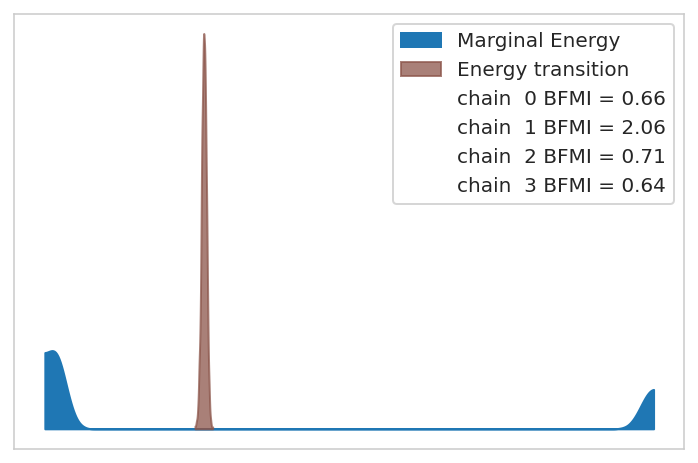

In [15]:
az.plot_energy(trace);

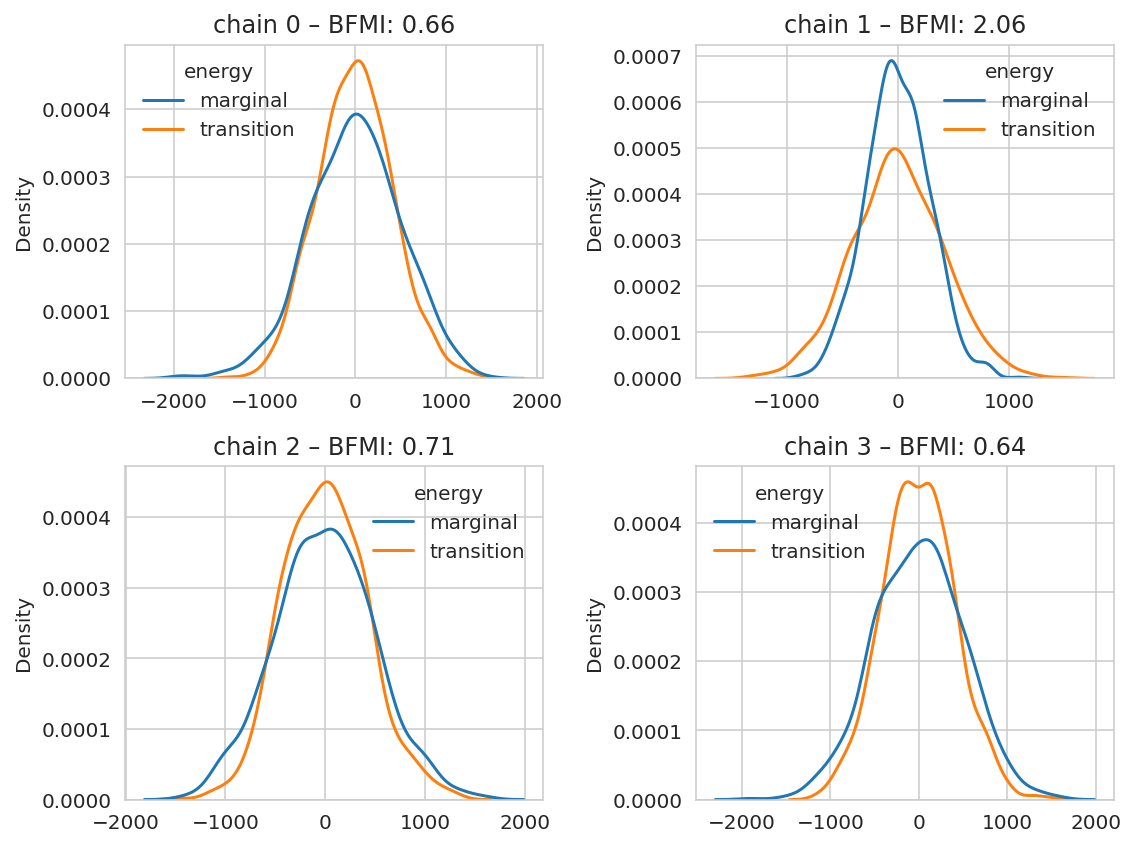

In [16]:
energy = trace.sample_stats.energy.values
marginal_e = pd.DataFrame((energy - energy.mean(axis=1)[:, None]).T).assign(
    energy="marginal"
)
transition_e = pd.DataFrame((energy[:, :-1] - energy[:, 1:]).T).assign(
    energy="transition"
)
energy_df = pd.concat([marginal_e, transition_e]).reset_index(drop=True)
bfmi = az.bfmi(trace)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for i, ax in enumerate(axes.flatten()):
    sns.kdeplot(data=energy_df, x=i, hue="energy", ax=ax)
    ax.set_title(f"chain {i} – BFMI: {bfmi[i]:0.2f}")
    ax.set_xlabel(None)
    xmin, _ = ax.get_xlim()
    _, ymax = ax.get_ylim()
    ax.get_legend().set_frame_on(False)

fig.tight_layout()
plt.show()

In [17]:
stats = ["step_size", "n_steps", "tree_depth", "acceptance_rate", "energy"]
trace.sample_stats.get(stats).to_dataframe().groupby("chain").mean()

step_size  n_steps  tree_depth  acceptance_rate        energy
chain                                                                  
0      8.936947e-03    511.0         9.0         0.978535  2.452054e+06
1      7.829003e-21   1023.0        10.0         0.986086  2.551388e+06
2      1.215136e-02   1023.0        10.0         0.969588  2.452130e+06
3      1.044637e-02    511.0         9.0         0.977086  2.452060e+06

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


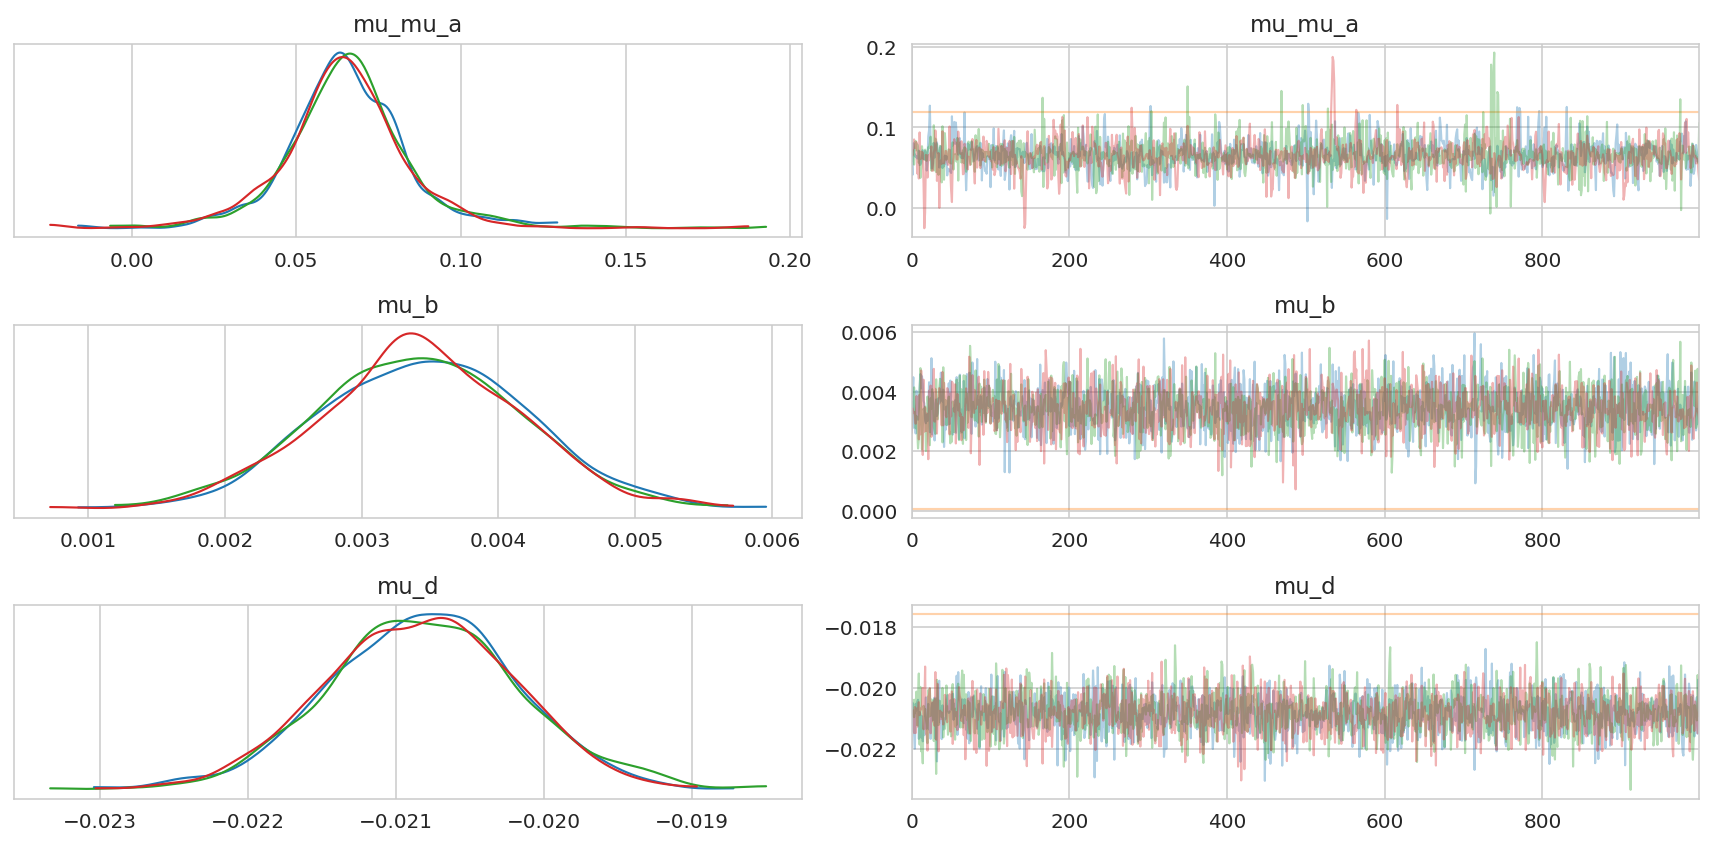

In [18]:
az.plot_trace(trace, var_names=["mu_mu_a", "mu_b", "mu_d"], compact=False)
plt.tight_layout()

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/hom

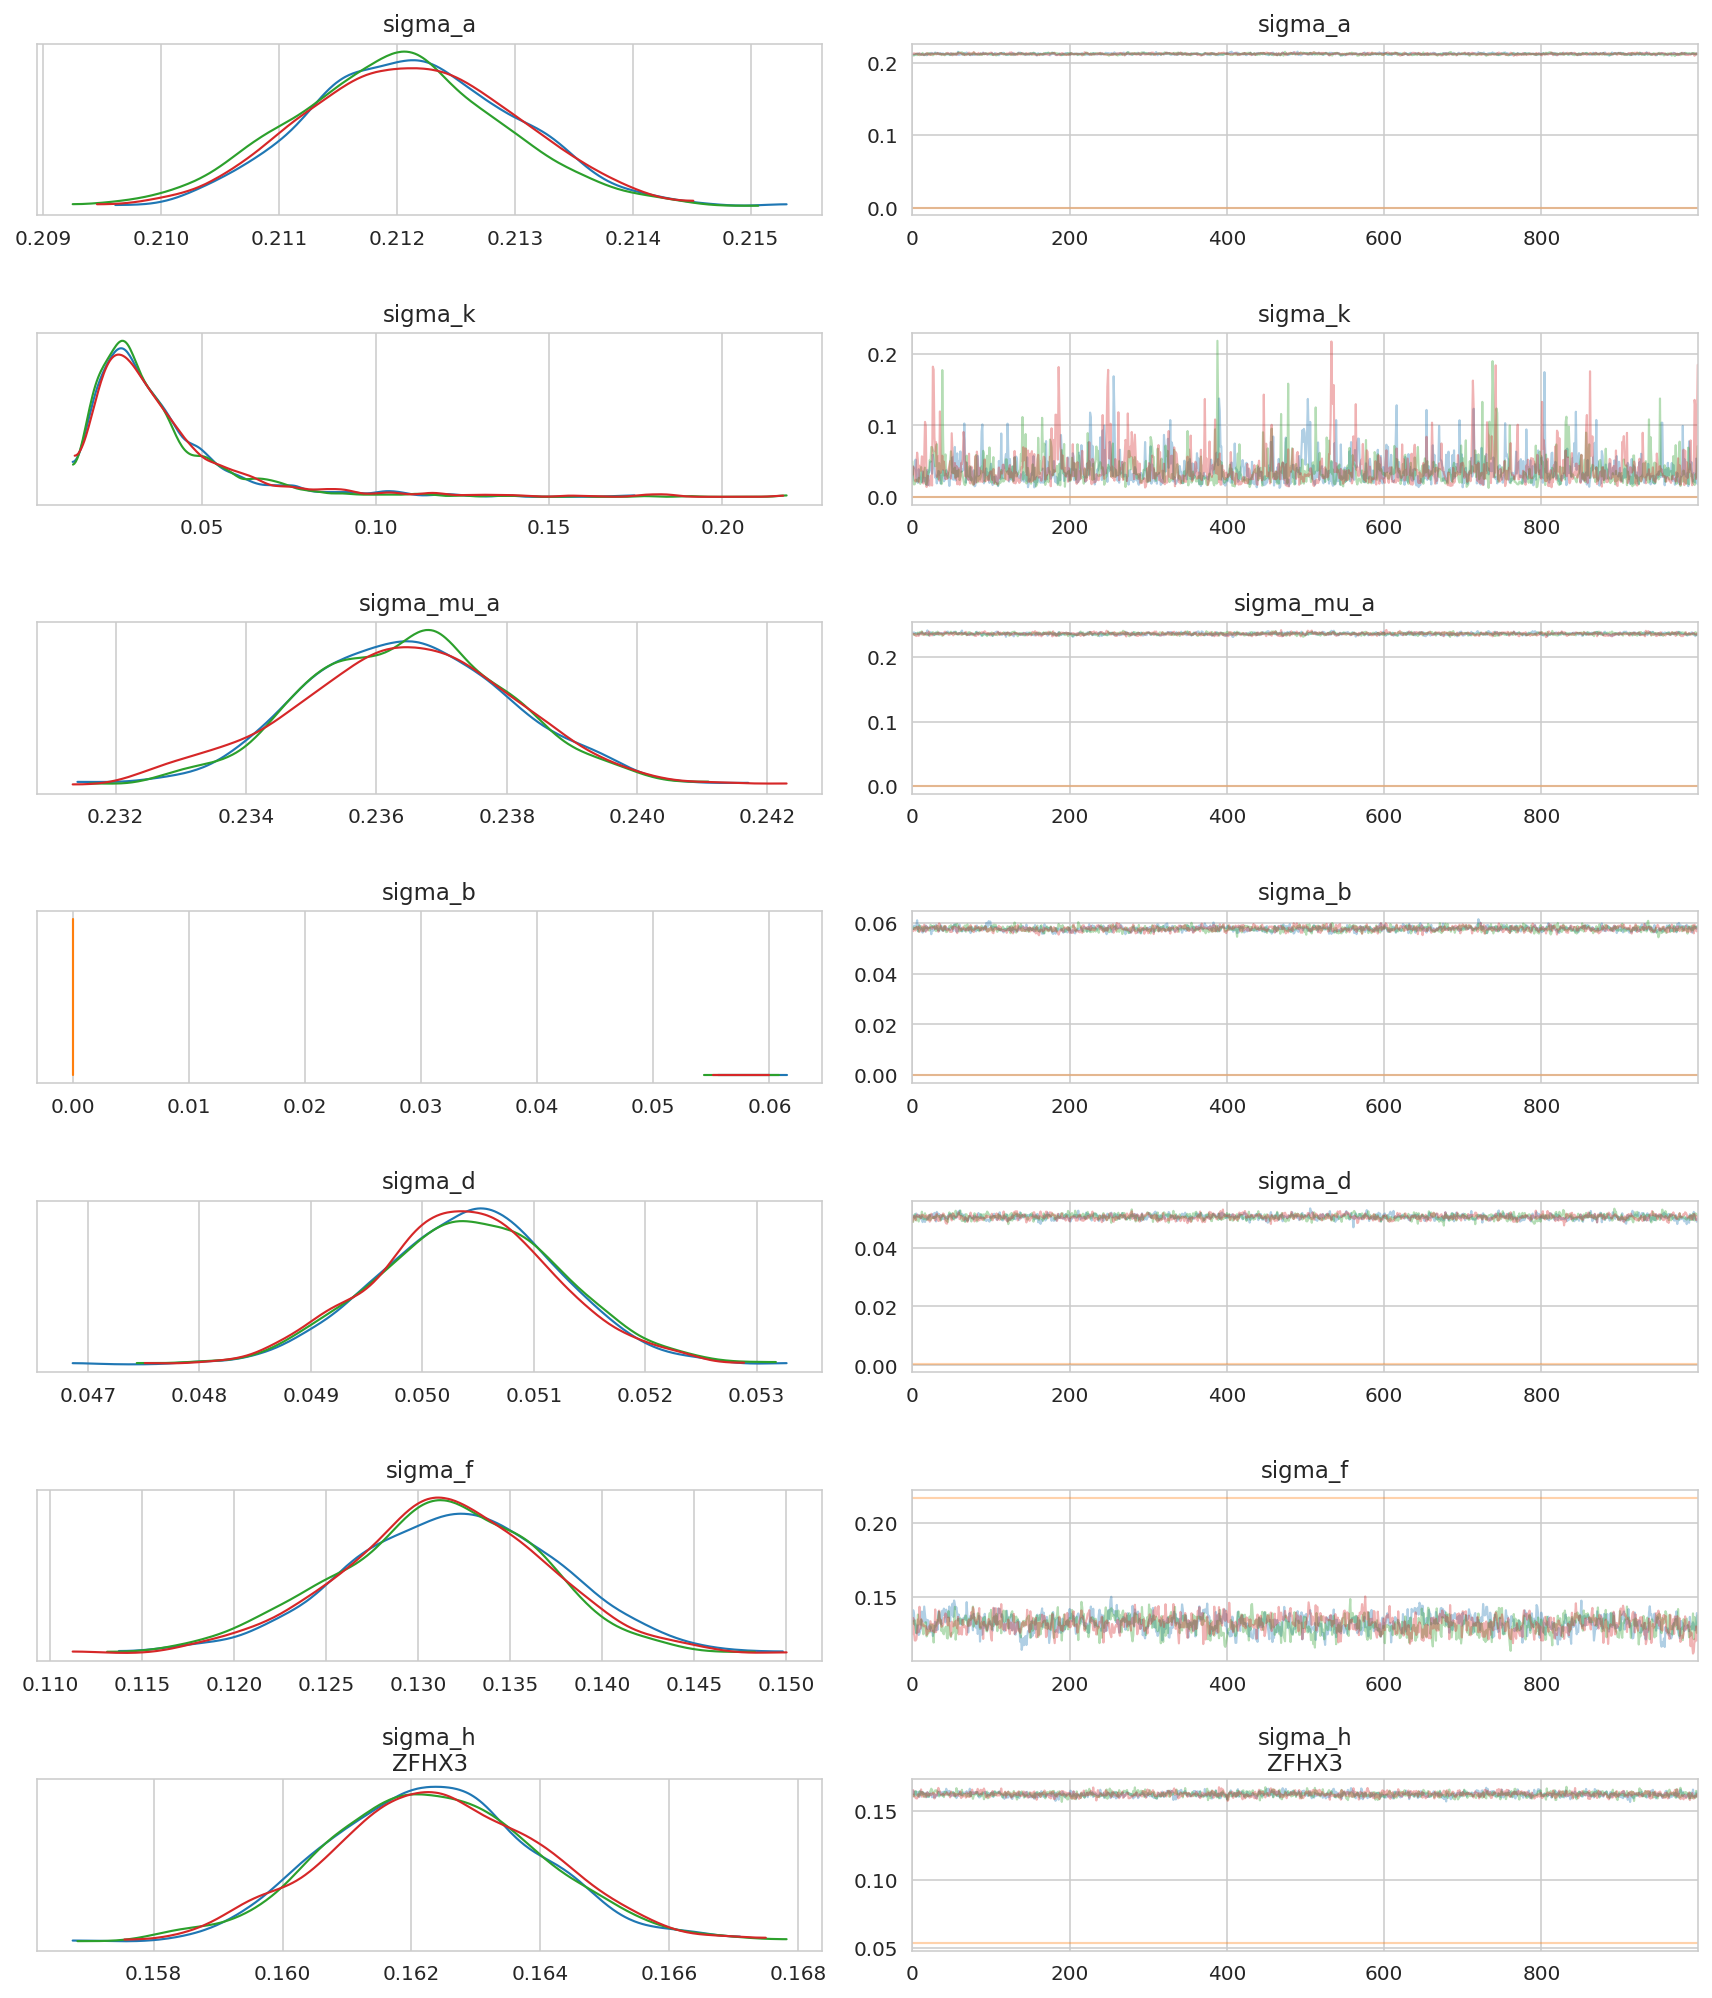

In [19]:
az.plot_trace(trace, var_names=["^sigma_*"], filter_vars="regex", compact=False)
plt.tight_layout()

In [20]:
sigmas = ["sigma_mu_a", "sigma_b", "sigma_d", "sigma_f", "sigma_k"]
trace.posterior.get(sigmas).mean(dim="draw").to_dataframe()

sigma_mu_a       sigma_b   sigma_d   sigma_f       sigma_k
chain                                                              
0      2.364676e-01  5.774309e-02  0.050418  0.131896  3.737015e-02
1      3.154574e-19  1.255465e-22  0.000353  0.217349  1.854613e-11
2      2.364556e-01  5.770427e-02  0.050426  0.130979  3.692001e-02
3      2.364197e-01  5.772364e-02  0.050369  0.131410  3.997159e-02

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


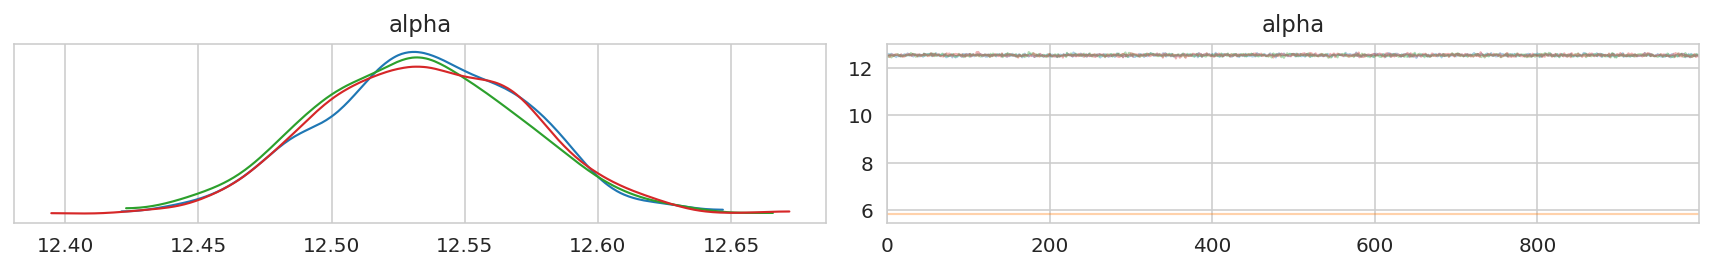

In [21]:
az.plot_trace(trace, var_names=["alpha"], compact=False)
plt.tight_layout()

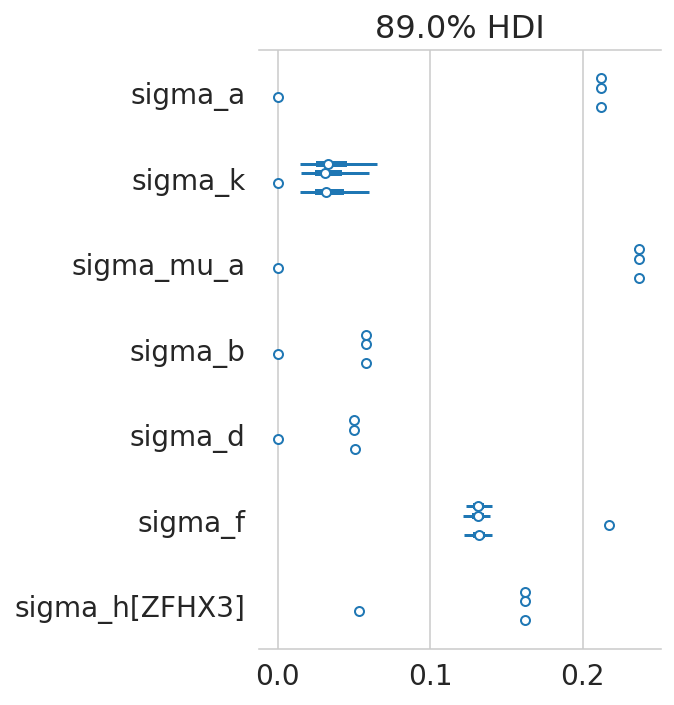

In [22]:
az.plot_forest(
    trace, var_names=["^sigma_*"], filter_vars="regex", combined=False, figsize=(5, 5)
)
plt.tight_layout()

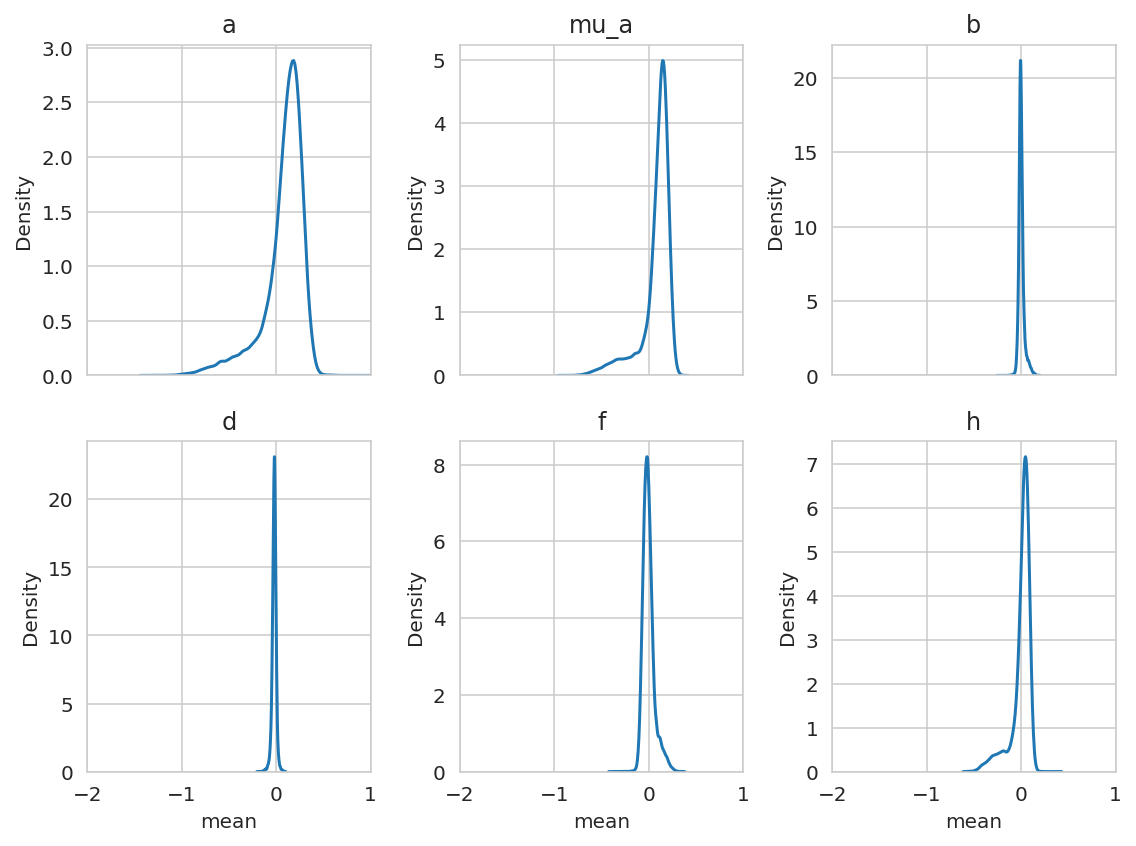

In [23]:
var_names = ["a", "mu_a", "b", "d", "f", "h"]
_, axes = plt.subplots(2, 3, figsize=(8, 6), sharex=True)
for ax, var_name in zip(axes.flatten(), var_names):
    x = prostate_post_summary.query(f"var_name == '{var_name}'")["mean"]
    sns.kdeplot(x=x, ax=ax)
    ax.set_title(var_name)
    ax.set_xlim(-2, 1)

plt.tight_layout()
plt.show()

In [24]:
sgrna_to_gene_map = (
    prostate_data.copy()[["hugo_symbol", "sgrna"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

In [25]:
prostate_post_summary.query("var_name == 'mu_a'").sort_values("mean").pipe(head_tail, 5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
7785      mu_a[KIF11] -0.894  0.592    -1.343      0.119      0.292    0.223   
6987      mu_a[HSPE1] -0.764  0.517    -1.159      0.119      0.254    0.194   
14744     mu_a[SPC24] -0.762  0.516    -1.161      0.119      0.254    0.194   
12653       mu_a[RAN] -0.749  0.509    -1.143      0.119      0.250    0.191   
13210     mu_a[RPL12] -0.742  0.505    -1.133      0.119      0.248    0.190   
1029     mu_a[ARMCX4]  0.315  0.139     0.119      0.480      0.057    0.042   
940    mu_a[ARHGAP44]  0.318  0.141     0.119      0.484      0.058    0.043   
2455       mu_a[CCNF]  0.322  0.148     0.119      0.504      0.059    0.044   
6762   mu_a[HLA-DQB1]  0.328  0.151     0.119      0.511      0.061    0.045   
16214      mu_a[TP53]  0.352  0.157     0.119      0.528      0.068    0.051   

       ess_bulk  ess_tail  r_hat var_name  
7785        7.0    1785.0   1.53     mu_a  
6987        7.0    1770.0   1.53     mu_a  
14744       7.0    3007.0   1.52     mu_a  
12653       7.0    1699.0   1.53     mu_a  
13210       7.0    2359.0   1.53     mu_a  
1029        8.0       4.0   1.49     mu_a  
940         7.0       4.0   1.49     mu_a  
2455        8.0       4.0   1.48     mu_a  
6762        8.0       4.0   1.49     mu_a  
16214       7.0       4.0   1.51     mu_a

In [26]:
prostate_post_summary.query("var_name == 'b'").sort_values("mean").pipe(head_tail, 5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
22902    b[EP300] -0.243  0.145    -0.371      0.000      0.070    0.053   
34344     b[TP63] -0.134  0.085    -0.221      0.000      0.039    0.029   
33098    b[STAG2] -0.131  0.083    -0.216      0.000      0.038    0.029   
23683    b[FOXA1] -0.125  0.082    -0.212      0.000      0.036    0.027   
22614      b[EBP] -0.125  0.083    -0.216      0.000      0.036    0.027   
19386  b[ATP6V1F]  0.166  0.103     0.000      0.268      0.048    0.036   
27507   b[MRPL57]  0.168  0.104     0.000      0.268      0.049    0.037   
24316      b[GPI]  0.181  0.111     0.000      0.288      0.052    0.040   
18591    b[AIFM1]  0.189  0.116     0.000      0.301      0.055    0.042   
27884    b[NARS2]  0.190  0.115     0.000      0.296      0.055    0.042   

       ess_bulk  ess_tail  r_hat var_name  
22902       7.0    2134.0   1.53        b  
34344       7.0    2593.0   1.52        b  
33098       7.0    2384.0   1.52        b  
23683       7.0    2007.0   1.52        b  
22614       7.0    2059.0   1.52        b  
19386       7.0       4.0   1.52        b  
27507       7.0       4.0   1.52        b  
24316       7.0       4.0   1.53        b  
18591       7.0       4.0   1.53        b  
27884       7.0       4.0   1.53        b

In [27]:
prostate_post_summary.query("var_name == 'd'").sort_values("mean").pipe(head_tail, 5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
39174   d[CHMP3] -0.195  0.107    -0.292     -0.018      0.051    0.039   
37445  d[ATP1A1] -0.184  0.103    -0.282     -0.017      0.048    0.037   
52640   d[TRIT1] -0.159  0.089    -0.249     -0.017      0.041    0.031   
44642   d[LONP1] -0.159  0.089    -0.248     -0.017      0.041    0.031   
52955   d[UBE2N] -0.156  0.087    -0.243     -0.018      0.040    0.030   
40992    d[ENO1]  0.084  0.068    -0.018      0.159      0.030    0.022   
51556   d[TARS2]  0.085  0.068    -0.018      0.161      0.030    0.023   
42786    d[HCCS]  0.085  0.069    -0.017      0.164      0.030    0.022   
45608  d[MRPL39]  0.091  0.071    -0.017      0.170      0.031    0.024   
40413   d[DMAC1]  0.094  0.074    -0.017      0.175      0.033    0.024   

       ess_bulk  ess_tail  r_hat var_name  
39174       7.0    2660.0   1.52        d  
37445       7.0    2114.0   1.53        d  
52640       7.0    2684.0   1.52        d  
44642       7.0    1996.0   1.52        d  
52955       7.0    1992.0   1.52        d  
40992       7.0       4.0   1.52        d  
51556       7.0       4.0   1.52        d  
42786       7.0       4.0   1.52        d  
45608       7.0       4.0   1.52        d  
40413       7.0       4.0   1.52        d

In [28]:
prostate_post_summary.query("var_name == 'h'").sort_values("mean").pipe(head_tail, 5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
77155       h[ELL, ZFHX3] -0.569  0.335    -0.845     -0.003      0.163   
80261     h[KIF11, ZFHX3] -0.568  0.331    -0.847     -0.011      0.161   
88900     h[TRNT1, ZFHX3] -0.544  0.328    -0.816      0.011      0.160   
73737  h[ATP6V1B2, ZFHX3] -0.537  0.293    -0.782     -0.043      0.143   
83363     h[OSGEP, ZFHX3] -0.524  0.288    -0.773     -0.042      0.139   
86241  h[SERPINA7, ZFHX3]  0.184  0.110     0.027      0.312      0.046   
72883      h[AFF4, ZFHX3]  0.196  0.128     0.001      0.335      0.057   
77166      h[ELOA, ZFHX3]  0.212  0.135     0.005      0.357      0.060   
88690      h[TP53, ZFHX3]  0.227  0.157    -0.022      0.387      0.072   
77259     h[EP300, ZFHX3]  0.384  0.236    -0.009      0.595      0.114   

       mcse_sd  ess_bulk  ess_tail  r_hat var_name  
77155    0.125       7.0    1636.0   1.52        h  
80261    0.122       7.0    2908.0   1.53        h  
88900    0.122       7.0    2877.0   1.53        h  
73737    0.109       7.0    2103.0   1.52        h  
83363    0.106       7.0    2196.0   1.52        h  
86241    0.034       7.0       4.0   1.49        h  
72883    0.043       7.0       4.0   1.52        h  
77166    0.045       7.0       4.0   1.52        h  
88690    0.054       7.0       4.0   1.52        h  
77259    0.086       7.0       4.0   1.52        h

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/hom

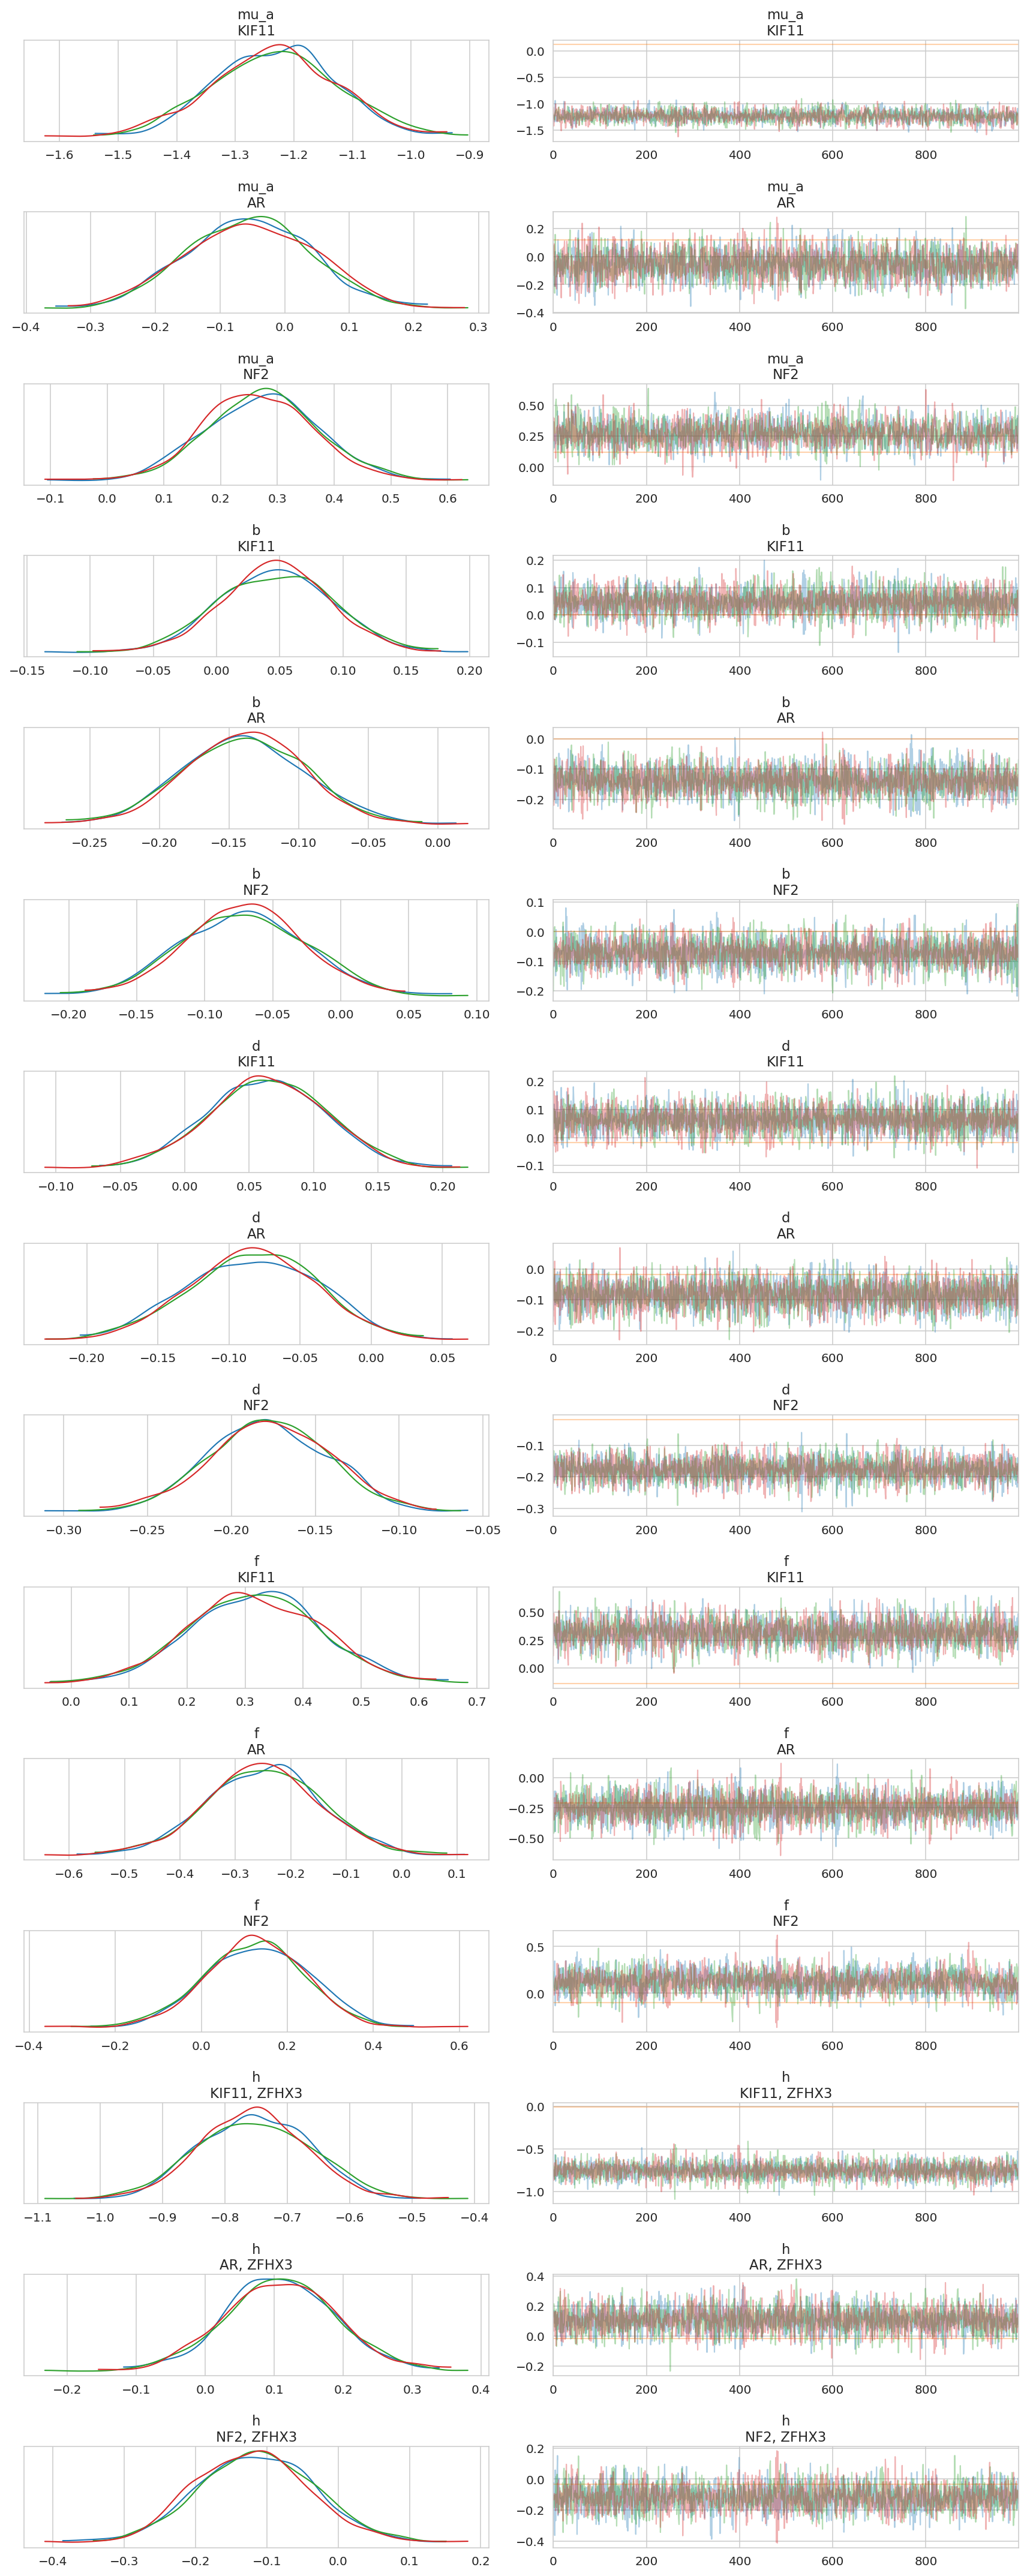

In [29]:
example_genes = ["KIF11", "AR", "NF2"]
az.plot_trace(
    trace,
    var_names=["mu_a", "b", "d", "f", "h"],
    coords={"gene": example_genes},
    compact=False,
)
plt.tight_layout()
plt.show()

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/hom

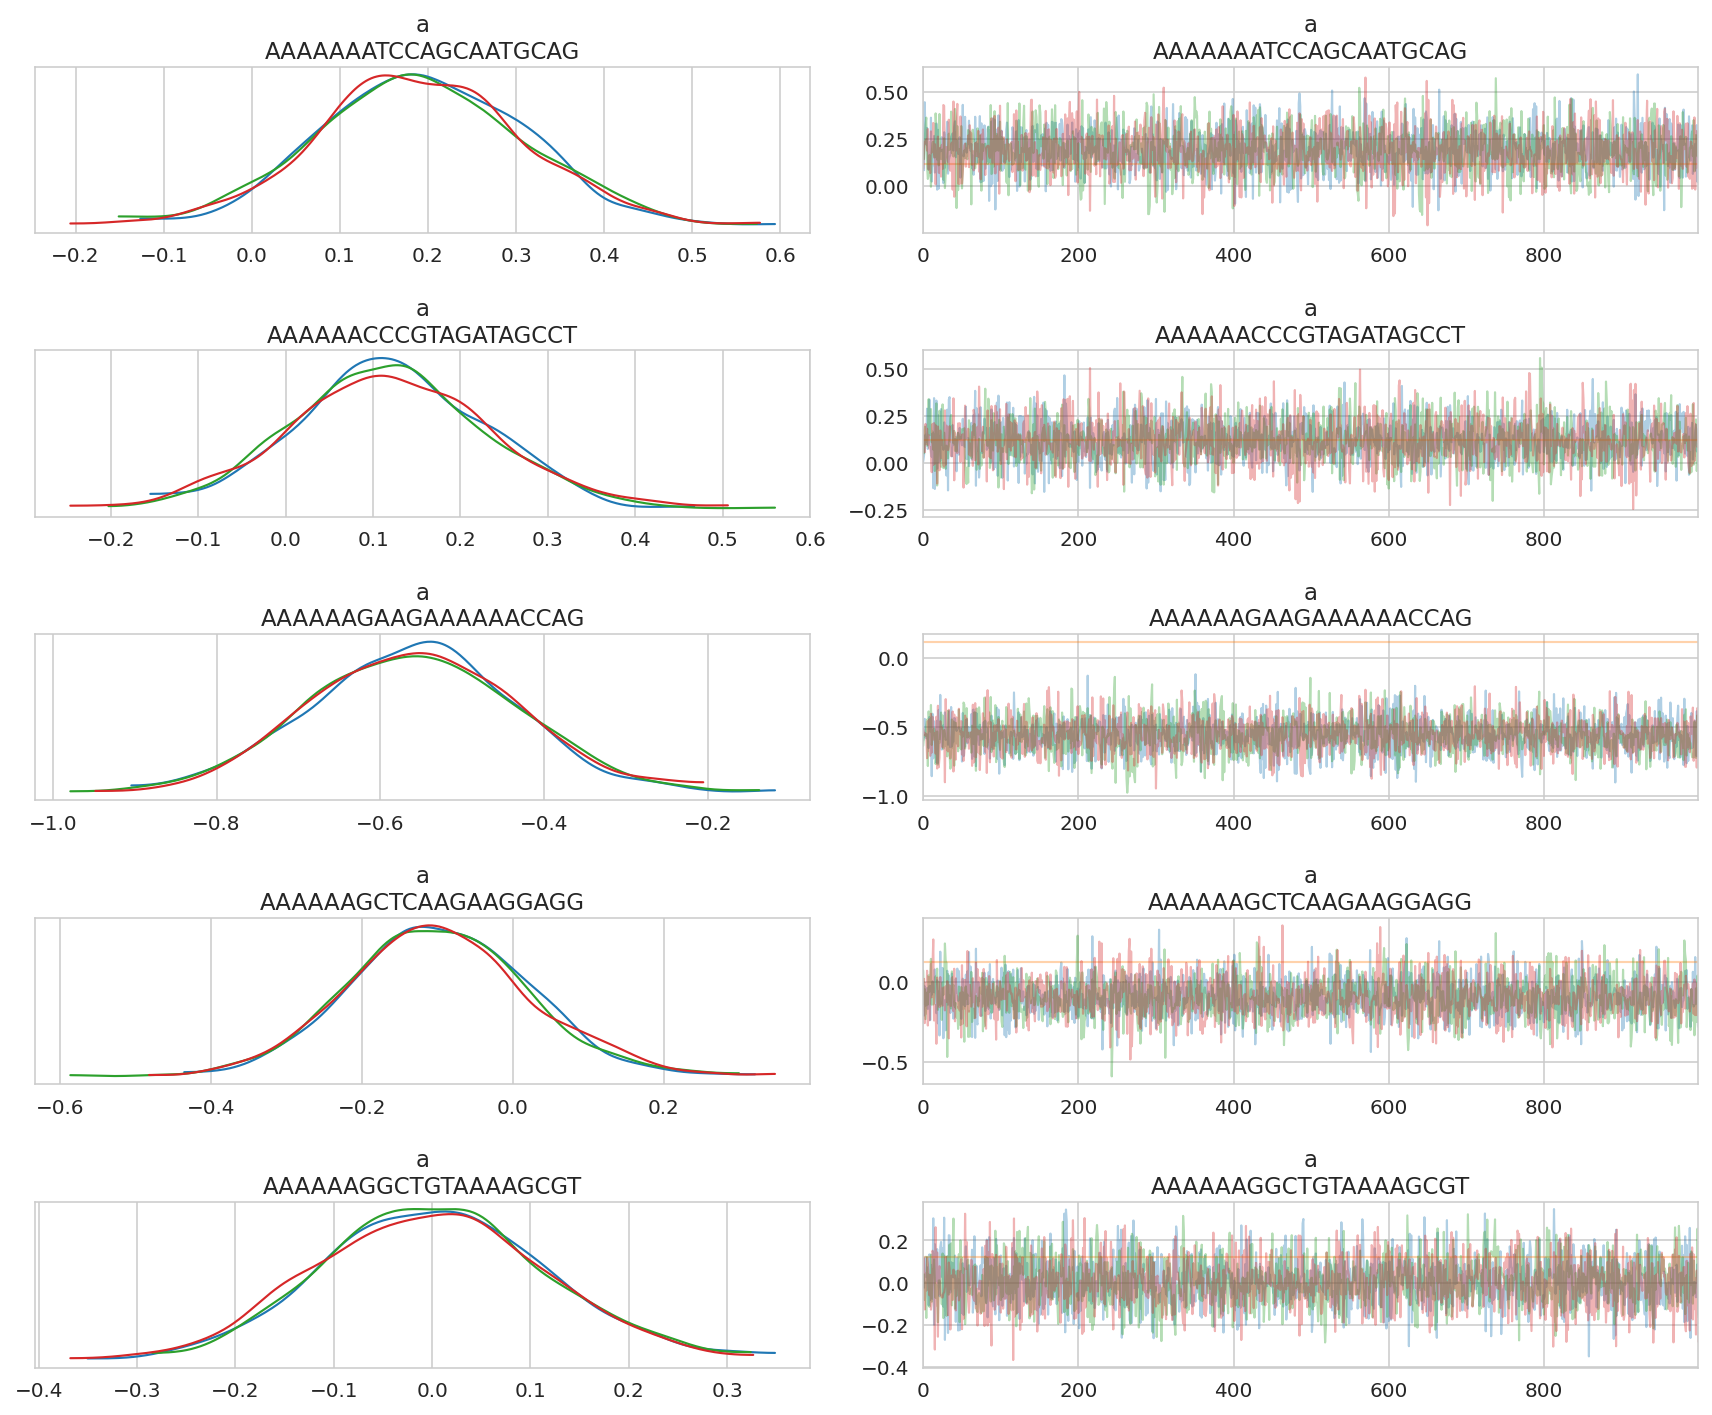

In [30]:
sgrnas_sample = trace.posterior.coords["sgrna"].values[:5]

az.plot_trace(trace, var_names="a", coords={"sgrna": sgrnas_sample}, compact=False)
plt.tight_layout()
plt.show()

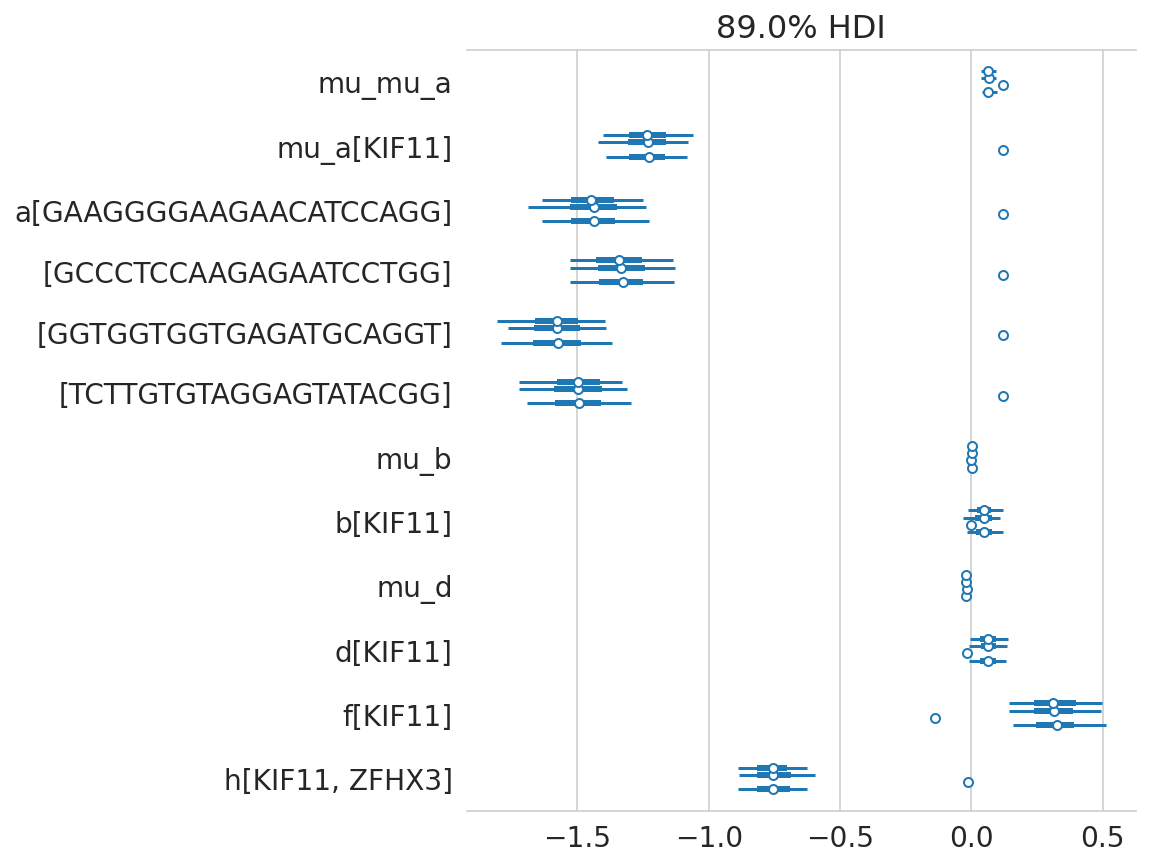

In [31]:
example_gene = "KIF11"
example_gene_sgrna = sgrna_to_gene_map.query(f"hugo_symbol == '{example_gene}'")[
    "sgrna"
].tolist()
az.plot_forest(
    trace,
    var_names=[
        "mu_mu_a",
        "mu_a",
        "a",
        "mu_b",
        "b",
        "mu_d",
        "d",
        # "mu_f",
        "f",
        "h",
    ],
    coords={"gene": [example_gene], "sgrna": example_gene_sgrna},
    combined=False,
    figsize=(6, 7),
)
plt.show()

In [32]:
prostate_post_summary.filter_string("var_name", "^sigma_*")

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
3          sigma_a  0.159  0.092     0.000      0.213      0.046    0.035   
4          sigma_k  0.029  0.025     0.000      0.054      0.008    0.006   
6       sigma_mu_a  0.177  0.102     0.000      0.238      0.051    0.039   
7          sigma_b  0.043  0.025     0.000      0.059      0.012    0.010   
8          sigma_d  0.038  0.022     0.000      0.051      0.011    0.008   
9          sigma_f  0.153  0.038     0.126      0.217      0.019    0.014   
10  sigma_h[ZFHX3]  0.135  0.047     0.054      0.164      0.023    0.018   

    ess_bulk  ess_tail  r_hat    var_name  
3        7.0       4.0   1.53     sigma_a  
4        7.0       4.0   1.53     sigma_k  
6        7.0       4.0   1.52  sigma_mu_a  
7        7.0      33.0   1.53     sigma_b  
8        7.0       4.0   1.53     sigma_d  
9        7.0    1174.0   1.53     sigma_f  
10       7.0       4.0   1.52     sigma_h

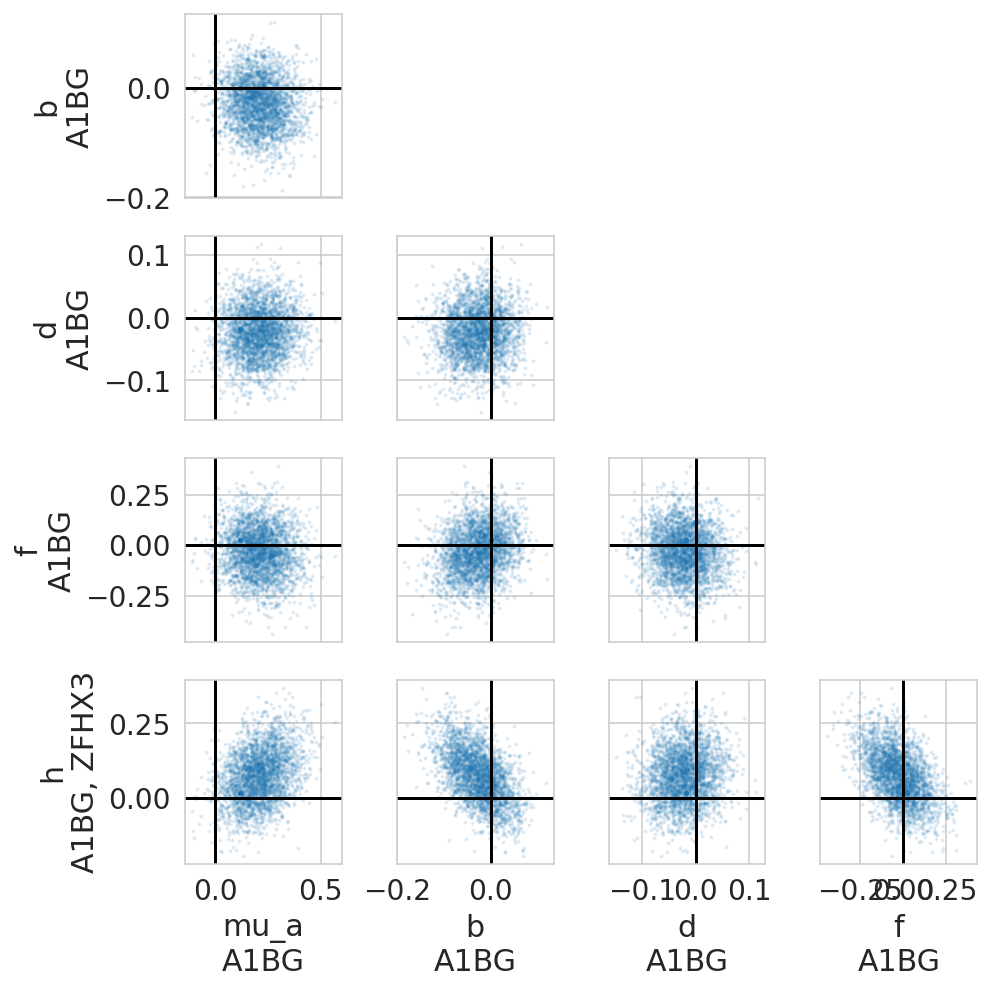

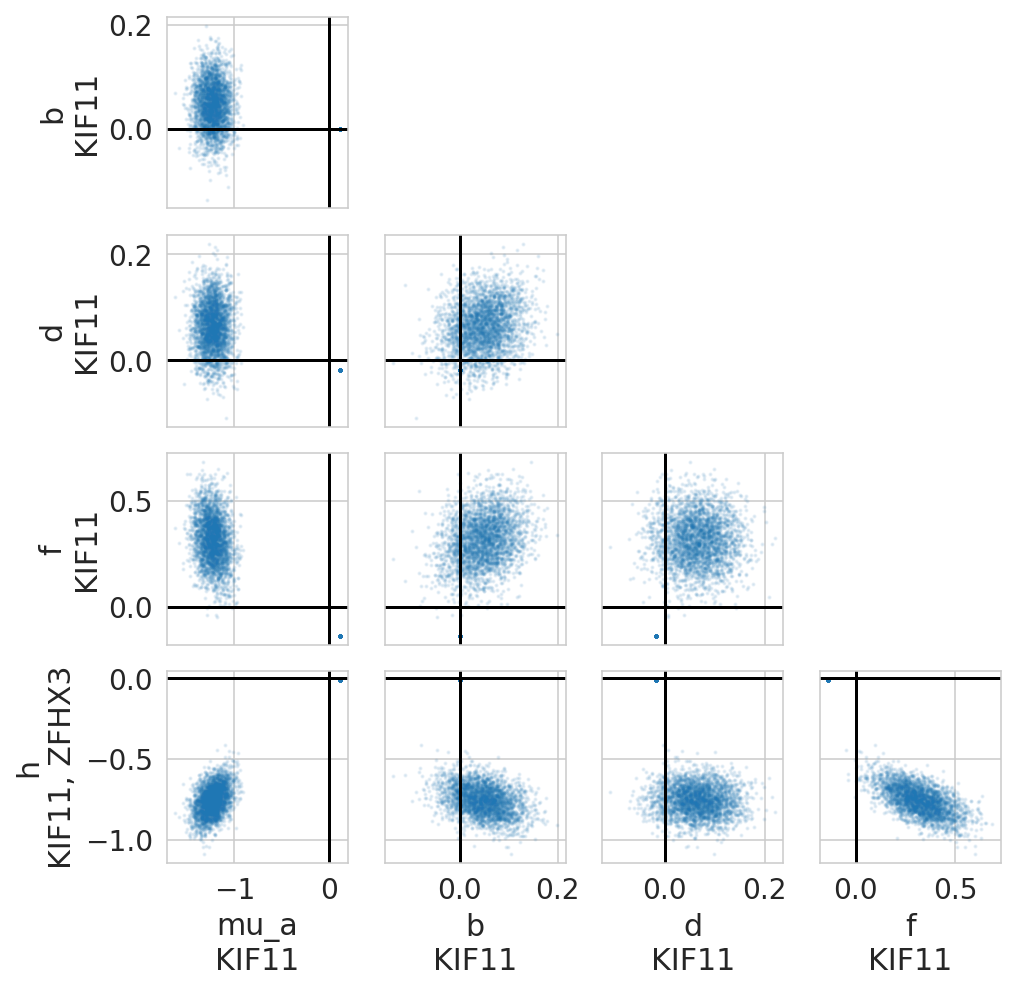

In [33]:
eg_gene = trace.posterior.coords["gene"].values[0]

for gene in [eg_gene, "KIF11"]:
    axes = az.plot_pair(
        trace,
        var_names=["mu_a", "b", "d", "f", "h"],
        coords={"gene": [gene]},
        figsize=(7, 7),
        scatter_kwargs={"alpha": 0.1, "markersize": 2},
    )
    for ax in axes.flatten():
        ax.axhline(0, color="k")
        ax.axvline(0, color="k")
    plt.tight_layout()
    plt.show()

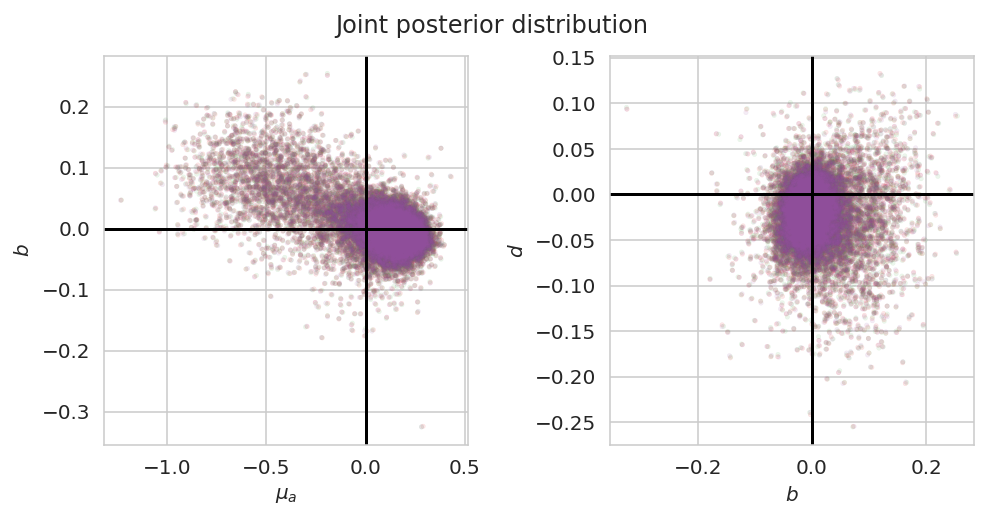

In [34]:
def _get_average_per_chain(trace: az.InferenceData, var_name: str) -> pd.DataFrame:
    return (
        trace.posterior[var_name]
        .mean(axis=(1))
        .to_dataframe()
        .reset_index()
        .astype({"chain": str})
    )


mu_a_post_avg = _get_average_per_chain(trace, "mu_a")
b_post_avg = _get_average_per_chain(trace, "b")
d_post_avg = _get_average_per_chain(trace, "d")

gene_post_avg = mu_a_post_avg.merge(b_post_avg, on=["chain", "gene"]).merge(
    d_post_avg, on=["chain", "gene"]
)


fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(7, 3.5))

ax = axes[0]
sns.scatterplot(
    data=gene_post_avg,
    x="mu_a",
    y="b",
    hue="chain",
    palette="Set1",
    alpha=0.1,
    edgecolor=None,
    s=5,
    ax=ax,
)
ax.set_xlabel(r"$\mu_a$")
ax.set_ylabel(r"$b$")


ax = axes[1]
sns.scatterplot(
    data=gene_post_avg,
    x="b",
    y="d",
    hue="chain",
    palette="Set1",
    alpha=0.1,
    edgecolor=None,
    s=5,
    ax=ax,
)
ax.set_xlabel(r"$b$")
ax.set_ylabel(r"$d$")

for ax in axes.flatten():
    ax.axhline(color="k")
    ax.axvline(color="k")
    ax.get_legend().remove()


fig.tight_layout()
fig.suptitle("Joint posterior distribution", va="bottom")

plt.show()

In [35]:
genes_var_names = ["mu_a", "b", "d", "f"]
genes_var_names += [f"h[{g}]" for g in trace.posterior.coords["cancer_gene"].values]
gene_corr_post = (
    az.summary(trace, "genes_chol_cov_corr", kind="stats")
    .pipe(extract_coords_param_names, names=["d1", "d2"])
    .astype({"d1": int, "d2": int})
    .assign(
        p1=lambda d: [genes_var_names[i] for i in d["d1"]],
        p2=lambda d: [genes_var_names[i] for i in d["d2"]],
    )
    .assign(
        p1=lambda d: pd.Categorical(d["p1"], categories=d["p1"].unique(), ordered=True)
    )
    .assign(
        p2=lambda d: pd.Categorical(
            d["p2"], categories=d["p1"].cat.categories, ordered=True
        )
    )
)
gene_corr_post

mean     sd  hdi_5.5%  hdi_94.5%  d1  d2  \
genes_chol_cov_corr[0, 0]  1.000  0.000     1.000      1.000   0   0   
genes_chol_cov_corr[0, 1] -0.279  0.261    -0.429      0.256   0   1   
genes_chol_cov_corr[0, 2]  0.331  0.383     0.094      0.993   0   2   
genes_chol_cov_corr[0, 3] -0.356  0.199    -0.504     -0.015   0   3   
genes_chol_cov_corr[0, 4]  0.825  0.022     0.790      0.846   0   4   
genes_chol_cov_corr[1, 0] -0.279  0.261    -0.429      0.256   1   0   
genes_chol_cov_corr[1, 1]  1.000  0.000     1.000      1.000   1   1   
genes_chol_cov_corr[1, 2] -0.036  0.190    -0.366      0.284   1   2   
genes_chol_cov_corr[1, 3]  0.490  0.254     0.291      0.994   1   3   
genes_chol_cov_corr[1, 4] -0.450  0.215    -0.589     -0.056   1   4   
genes_chol_cov_corr[2, 0]  0.331  0.383     0.094      0.993   2   0   
genes_chol_cov_corr[2, 1] -0.036  0.190    -0.366      0.284   2   1   
genes_chol_cov_corr[2, 2]  1.000  0.000     1.000      1.000   2   2   
genes_chol_cov_corr[2, 3] -0.102  0.046    -0.160     -0.020   2   3   
genes_chol_cov_corr[2, 4]  0.296  0.298     0.106      0.812   2   4   
genes_chol_cov_corr[3, 0] -0.356  0.199    -0.504     -0.015   3   0   
genes_chol_cov_corr[3, 1]  0.490  0.254     0.291      0.994   3   1   
genes_chol_cov_corr[3, 2] -0.102  0.046    -0.160     -0.020   3   2   
genes_chol_cov_corr[3, 3]  1.000  0.000     1.000      1.000   3   3   
genes_chol_cov_corr[3, 4] -0.538  0.207    -0.685     -0.180   3   4   
genes_chol_cov_corr[4, 0]  0.825  0.022     0.790      0.846   4   0   
genes_chol_cov_corr[4, 1] -0.450  0.215    -0.589     -0.056   4   1   
genes_chol_cov_corr[4, 2]  0.296  0.298     0.106      0.812   4   2   
genes_chol_cov_corr[4, 3] -0.538  0.207    -0.685     -0.180   4   3   
genes_chol_cov_corr[4, 4]  1.000  0.000     1.000      1.000   4   4   

                                 p1        p2  
genes_chol_cov_corr[0, 0]      mu_a      mu_a  
genes_chol_cov_corr[0, 1]      mu_a         b  
genes_chol_cov_corr[0, 2]      mu_a         d  
genes_chol_cov_corr[0, 3]      mu_a         f  
genes_chol_cov_corr[0, 4]      mu_a  h[ZFHX3]  
genes_chol_cov_corr[1, 0]         b      mu_a  
genes_chol_cov_corr[1, 1]         b         b  
genes_chol_cov_corr[1, 2]         b         d  
genes_chol_cov_corr[1, 3]         b         f  
genes_chol_cov_corr[1, 4]         b  h[ZFHX3]  
genes_chol_cov_corr[2, 0]         d      mu_a  
genes_chol_cov_corr[2, 1]         d         b  
genes_chol_cov_corr[2, 2]         d         d  
genes_chol_cov_corr[2, 3]         d         f  
genes_chol_cov_corr[2, 4]         d  h[ZFHX3]  
genes_chol_cov_corr[3, 0]         f      mu_a  
genes_chol_cov_corr[3, 1]         f         b  
genes_chol_cov_corr[3, 2]         f         d  
genes_chol_cov_corr[3, 3]         f         f  
genes_chol_cov_corr[3, 4]         f  h[ZFHX3]  
genes_chol_cov_corr[4, 0]  h[ZFHX3]      mu_a  
genes_chol_cov_corr[4, 1]  h[ZFHX3]         b  
genes_chol_cov_corr[4, 2]  h[ZFHX3]         d  
genes_chol_cov_corr[4, 3]  h[ZFHX3]         f  
genes_chol_cov_corr[4, 4]  h[ZFHX3]  h[ZFHX3]

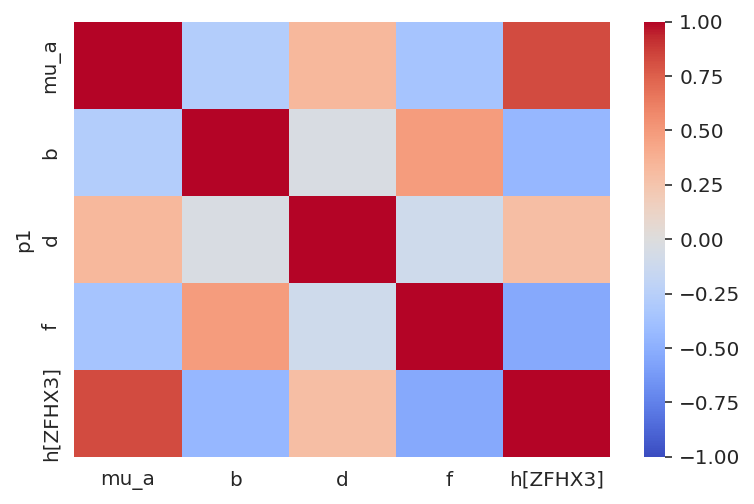

In [36]:
plot_df = gene_corr_post.pivot_wider("p1", "p2", "mean").set_index("p1")
sns.heatmap(plot_df, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

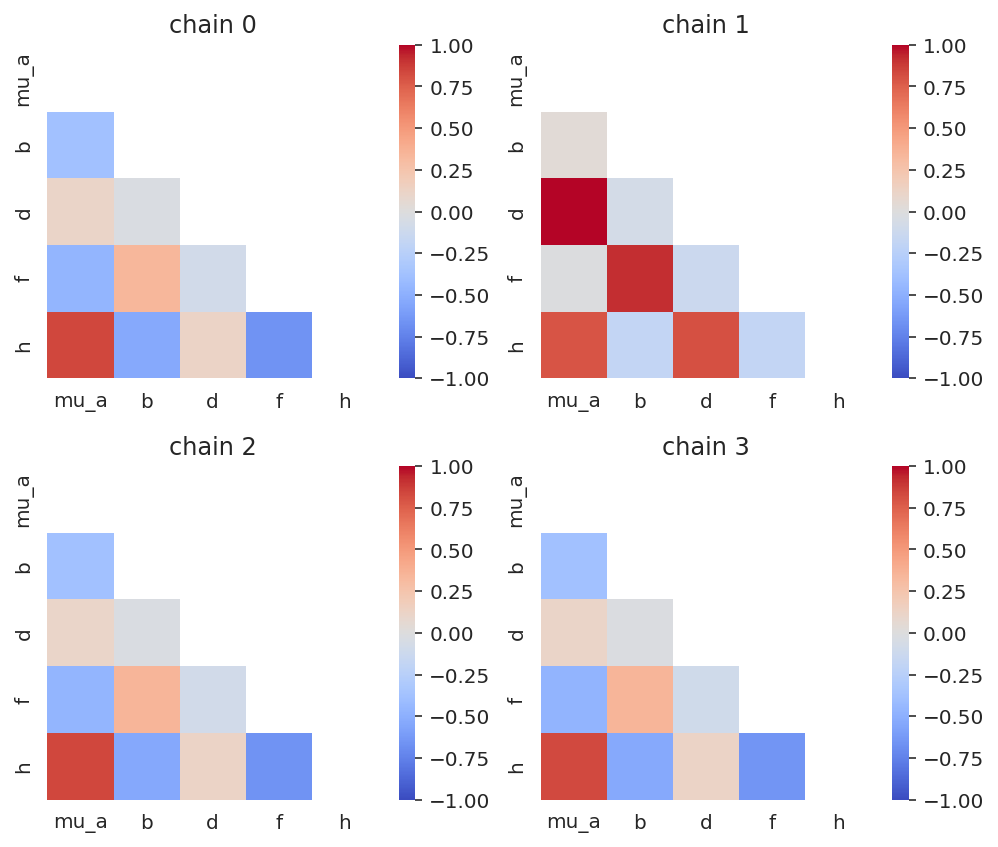

In [37]:
genes_var_corr = trace.posterior["genes_chol_cov_corr"].mean(axis=(1))
genes_var_names = ["mu_a", "b", "d", "f", "h"]
fig, axes = plt.subplots(2, 2, figsize=(7, 6))

for c, ax in enumerate(axes.flatten()):
    data = genes_var_corr[c, :, :].values.copy()
    np.fill_diagonal(data, np.nan)
    data[~np.tril(data).astype(bool)] = np.nan
    sns.heatmap(data, vmin=-1, vmax=1, cmap="coolwarm", ax=ax)
    ax.set_xticklabels(genes_var_names)
    ax.set_yticklabels(genes_var_names)
    ax.set_title(f"chain {c}")

fig.tight_layout()
plt.show()

In [38]:
cancer_genes = trace.posterior.coords["cancer_gene"].values.tolist()
cancer_gene_mutants = (
    valid_prostate_data.filter_column_isin("hugo_symbol", cancer_genes)[
        ["hugo_symbol", "depmap_id", "is_mutated"]
    ]
    .drop_duplicates()
    .assign(is_mutated=lambda d: d["is_mutated"].map({True: "X", False: ""}))
    .pivot_wider("depmap_id", names_from="hugo_symbol", values_from="is_mutated")
    .set_index("depmap_id")
)
cancer_gene_mutants

ZFHX3
depmap_id       
ACH-000115      
ACH-000977     X
ACH-001453      
ACH-001627     X
ACH-001648

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


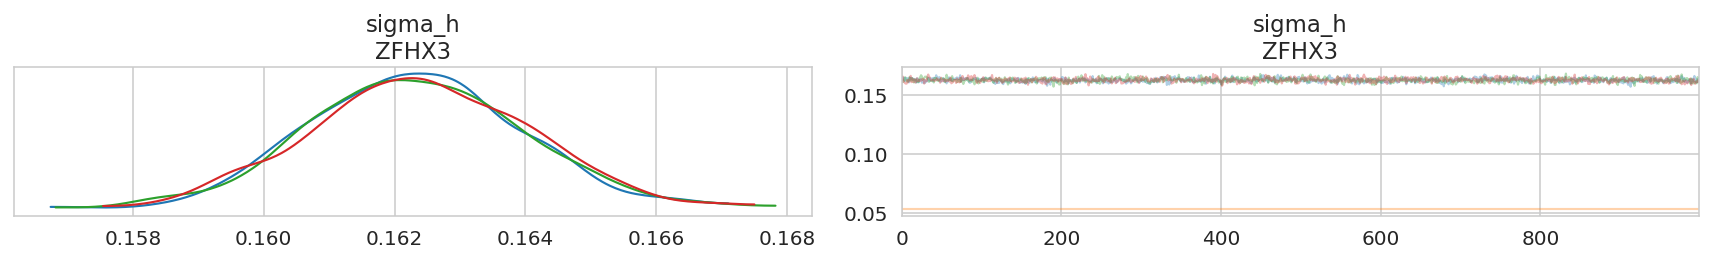

In [39]:
az.plot_trace(trace, var_names=["sigma_h"], compact=False)
plt.tight_layout()
plt.show()

In [40]:
h_post_summary = (
    prostate_post_summary.query("var_name == 'h'")
    .reset_index(drop=True)
    .pipe(
        extract_coords_param_names,
        names=["hugo_symbol", "cancer_gene"],
        col="parameter",
    )
)
h_post_summary.head()

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0     h[A1BG, ZFHX3]  0.060  0.078    -0.059      0.187      0.012    0.009   
1     h[A1CF, ZFHX3]  0.093  0.081     0.003      0.213      0.027    0.019   
2      h[A2M, ZFHX3]  0.091  0.081    -0.001      0.229      0.021    0.015   
3    h[A2ML1, ZFHX3] -0.000  0.062    -0.110      0.097      0.001    0.007   
4  h[A3GALT2, ZFHX3]  0.025  0.064    -0.077      0.133      0.001    0.007   

   ess_bulk  ess_tail  r_hat var_name hugo_symbol cancer_gene  
0      60.0    2183.0   1.10        h        A1BG       ZFHX3  
1      11.0       5.0   1.29        h        A1CF       ZFHX3  
2      17.0    1912.0   1.16        h         A2M       ZFHX3  
3    4505.0    2084.0   1.53        h       A2ML1       ZFHX3  
4    4673.0    2305.0   1.53        h     A3GALT2       ZFHX3

In [41]:
h_post_summary.sort_values("mean").pipe(head_tail, n=5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
4668        h[ELL, ZFHX3] -0.569  0.335    -0.845     -0.003      0.163   
7774      h[KIF11, ZFHX3] -0.568  0.331    -0.847     -0.011      0.161   
16413     h[TRNT1, ZFHX3] -0.544  0.328    -0.816      0.011      0.160   
1250   h[ATP6V1B2, ZFHX3] -0.537  0.293    -0.782     -0.043      0.143   
10876     h[OSGEP, ZFHX3] -0.524  0.288    -0.773     -0.042      0.139   
13754  h[SERPINA7, ZFHX3]  0.184  0.110     0.027      0.312      0.046   
396        h[AFF4, ZFHX3]  0.196  0.128     0.001      0.335      0.057   
4679       h[ELOA, ZFHX3]  0.212  0.135     0.005      0.357      0.060   
16203      h[TP53, ZFHX3]  0.227  0.157    -0.022      0.387      0.072   
4772      h[EP300, ZFHX3]  0.384  0.236    -0.009      0.595      0.114   

       mcse_sd  ess_bulk  ess_tail  r_hat var_name hugo_symbol cancer_gene  
4668     0.125       7.0    1636.0   1.52        h         ELL       ZFHX3  
7774     0.122       7.0    2908.0   1.53        h       KIF11       ZFHX3  
16413    0.122       7.0    2877.0   1.53        h       TRNT1       ZFHX3  
1250     0.109       7.0    2103.0   1.52        h    ATP6V1B2       ZFHX3  
10876    0.106       7.0    2196.0   1.52        h       OSGEP       ZFHX3  
13754    0.034       7.0       4.0   1.49        h    SERPINA7       ZFHX3  
396      0.043       7.0       4.0   1.52        h        AFF4       ZFHX3  
4679     0.045       7.0       4.0   1.52        h        ELOA       ZFHX3  
16203    0.054       7.0       4.0   1.52        h        TP53       ZFHX3  
4772     0.086       7.0       4.0   1.52        h       EP300       ZFHX3

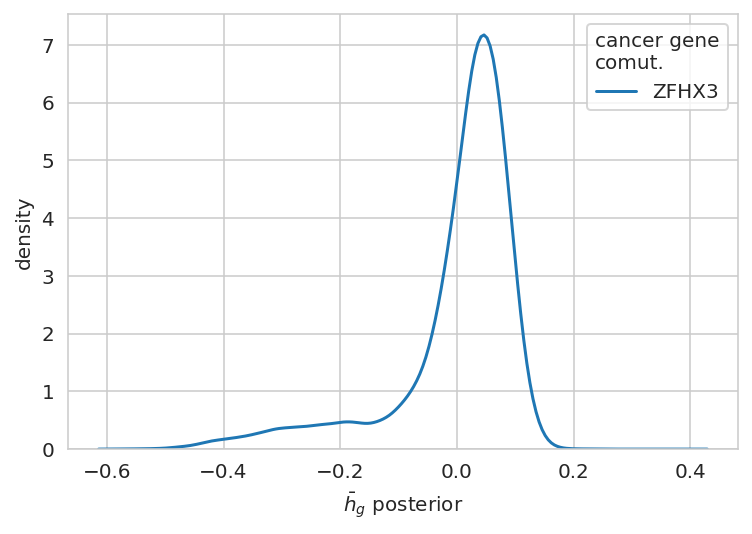

In [42]:
ax = sns.kdeplot(data=h_post_summary, x="mean", hue="cancer_gene")
ax.set_xlabel(r"$\bar{h}_g$ posterior")
ax.set_ylabel("density")
ax.get_legend().set_title("cancer gene\ncomut.")
plt.show()

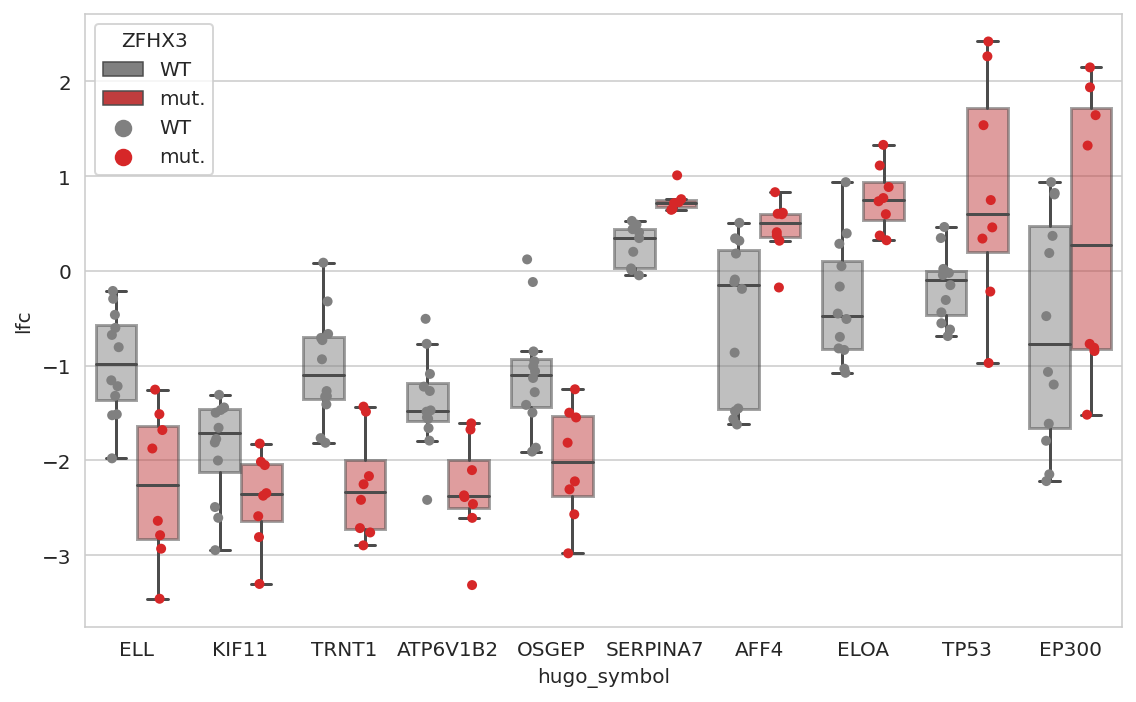

In [43]:
fig, axes = plt.subplots(
    len(cancer_genes), 1, squeeze=False, figsize=(8, len(cancer_genes) * 5)
)
for ax, cg in zip(axes.flatten(), cancer_genes):
    h_hits = (
        h_post_summary.filter_column_isin("cancer_gene", [cg])
        .sort_values("mean")
        .pipe(head_tail, n=5)["hugo_symbol"]
        .tolist()
    )

    h_hits_data = (
        valid_prostate_data.filter_column_isin("hugo_symbol", h_hits)
        .merge(cancer_gene_mutants.reset_index(), on="depmap_id")
        .reset_index()
        .astype({"hugo_symbol": str})
        .assign(
            hugo_symbol=lambda d: pd.Categorical(d["hugo_symbol"], categories=h_hits),
            _cg_mut=lambda d: d[cg].map({"X": "mut.", "": "WT"}),
        )
    )
    mut_pal = {"mut.": "tab:red", "WT": "gray"}
    sns.boxplot(
        data=h_hits_data,
        x="hugo_symbol",
        y="lfc",
        hue="_cg_mut",
        palette=mut_pal,
        ax=ax,
        showfliers=False,
        boxprops={"alpha": 0.5},
    )
    sns.stripplot(
        data=h_hits_data,
        x="hugo_symbol",
        y="lfc",
        hue="_cg_mut",
        dodge=True,
        palette=mut_pal,
        ax=ax,
    )
    ax.get_legend().set_title(cg)

plt.tight_layout()
plt.show()

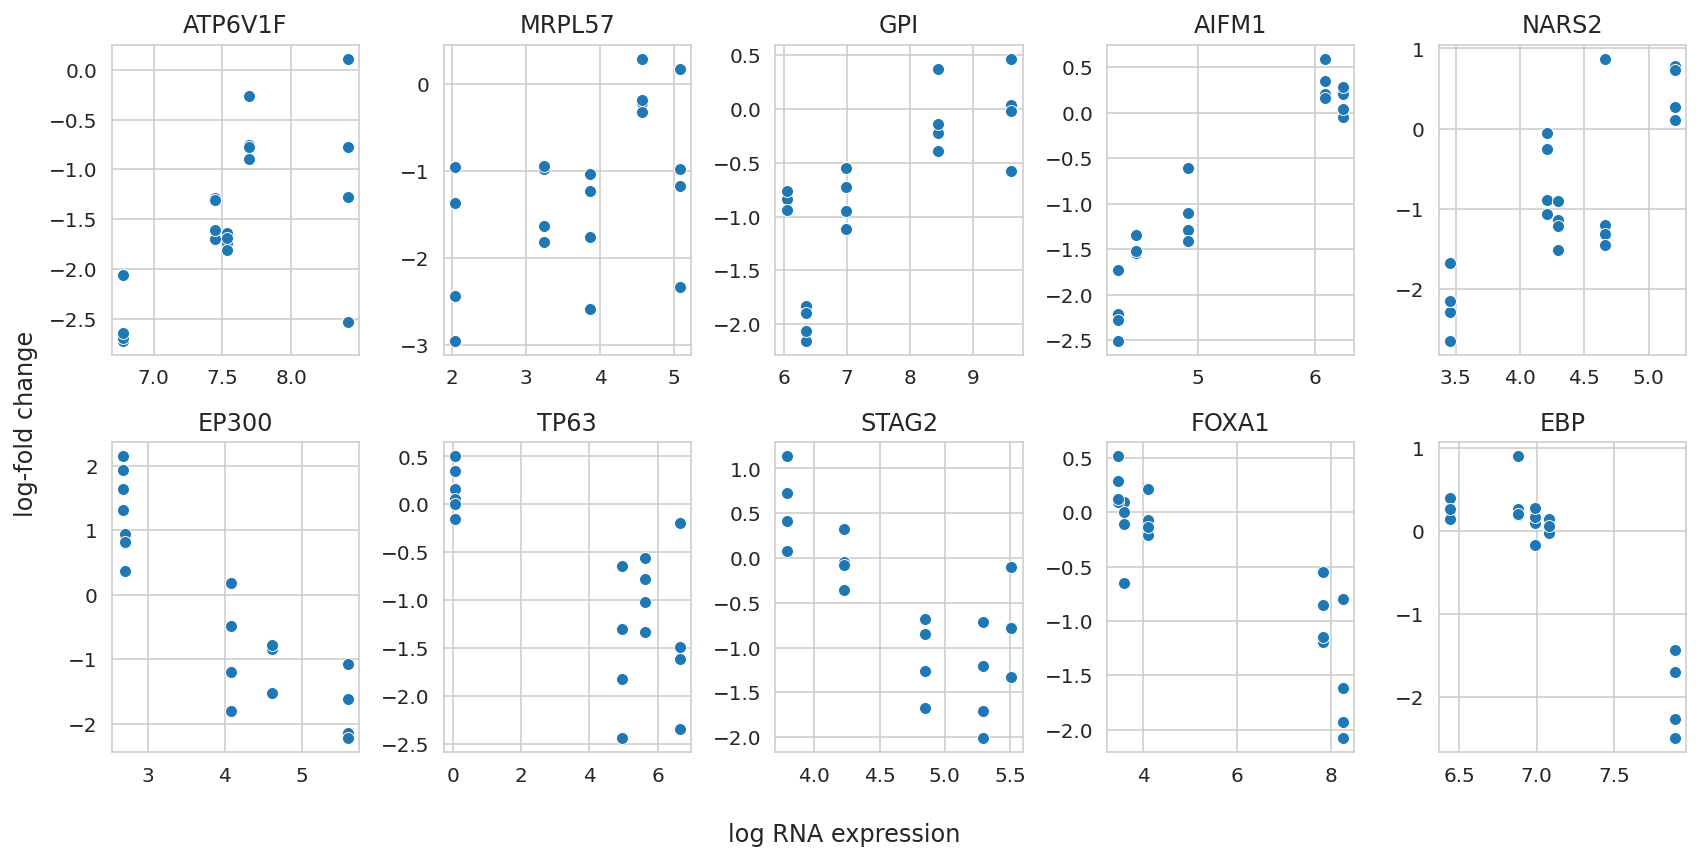

In [44]:
top_n = 5
top_b_hits = (
    prostate_post_summary.query("var_name == 'b'")
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, names=["hugo_symbol"], col="parameter")
    .pipe(head_tail, n=top_n)
)

negative_b = top_b_hits["hugo_symbol"][:top_n].values
positive_b = top_b_hits["hugo_symbol"][top_n:].values


fig, axes = plt.subplots(2, top_n, figsize=(12, 6))

for i, genes in enumerate([positive_b, negative_b]):
    for j, gene in enumerate(genes):
        ax = axes[i, j]
        ax.set_title(gene)
        obs_data = prostate_data.query(f"hugo_symbol == '{gene}'")
        sns.scatterplot(data=obs_data, x="rna_expr", y="lfc", ax=ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)


fig.supxlabel("log RNA expression")
fig.supylabel("log-fold change")

fig.tight_layout()
plt.show()

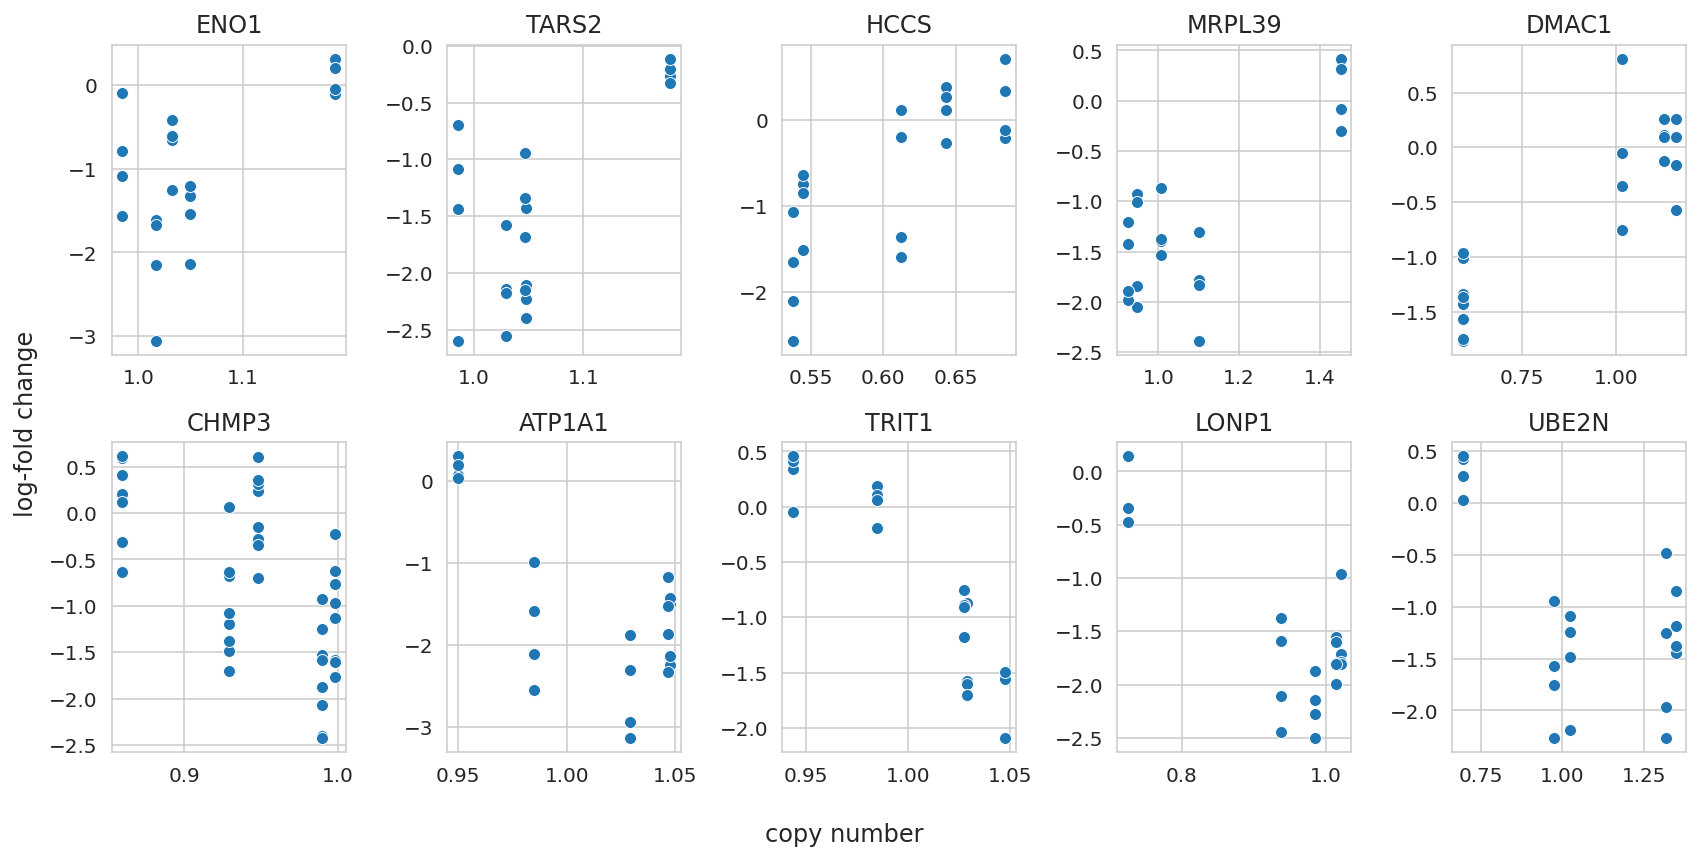

In [45]:
top_n = 5
top_d_hits = (
    prostate_post_summary.query("var_name == 'd'")
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, names=["hugo_symbol"], col="parameter")
    .pipe(head_tail, n=top_n)
)

negative_d = top_d_hits["hugo_symbol"][:top_n].values
positive_d = top_d_hits["hugo_symbol"][top_n:].values


fig, axes = plt.subplots(2, top_n, figsize=(12, 6))

for i, genes in enumerate([positive_d, negative_d]):
    for j, gene in enumerate(genes):
        ax = axes[i, j]
        ax.set_title(gene)
        obs_data = prostate_data.query(f"hugo_symbol == '{gene}'")
        sns.scatterplot(data=obs_data, x="copy_number", y="lfc", ax=ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)


fig.supxlabel("copy number")
fig.supylabel("log-fold change")
fig.tight_layout()
plt.show()

## PPC

In [46]:
n_examples = 40
n_chains, n_draws, n_data = trace.posterior_predictive["ct_final"].shape
ex_draws_idx = np.random.choice(
    np.arange(n_draws), size=n_examples // n_chains, replace=False
)
example_ppc_draws = trace.posterior_predictive["ct_final"][
    :, ex_draws_idx, :
].values.reshape(-1, n_data)
example_ppc_draws.shape

(40, 355308)

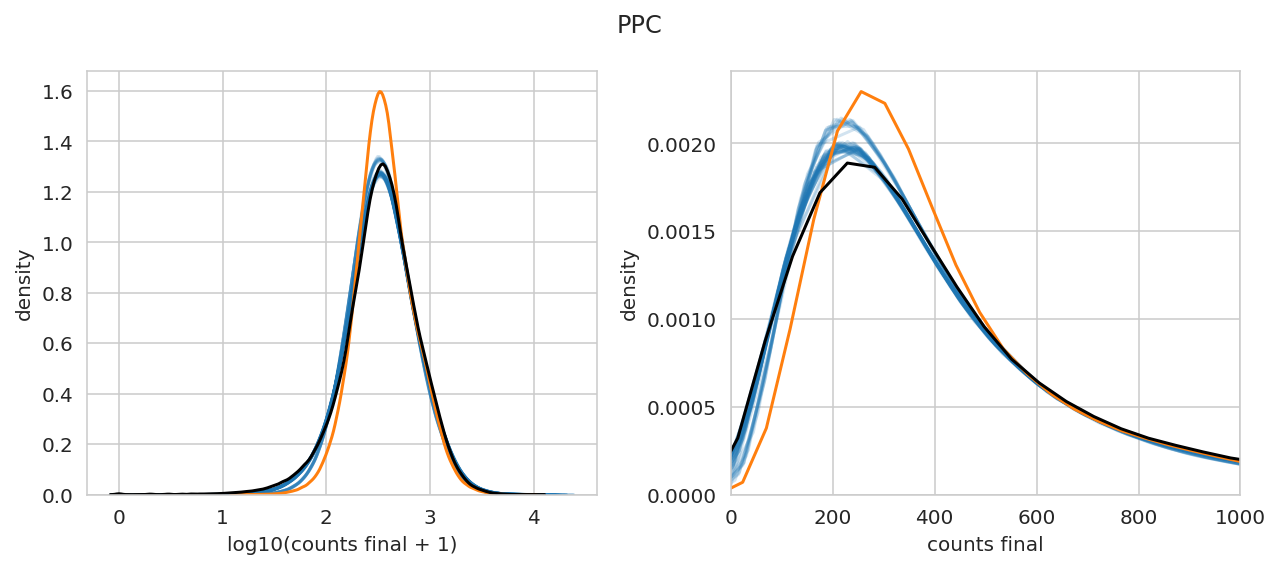

In [47]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharex=False, sharey=False)
ax1 = axes[0]
ax2 = axes[1]

pp_avg = trace.posterior_predictive["ct_final"].mean(axis=(0, 1))

for i in range(example_ppc_draws.shape[0]):
    sns.kdeplot(
        x=np.log10(example_ppc_draws[i, :] + 1), alpha=0.2, color="tab:blue", ax=ax1
    )

sns.kdeplot(x=np.log10(pp_avg + 1), color="tab:orange", ax=ax1)
sns.kdeplot(x=np.log10(valid_prostate_data["counts_final"] + 1), color="k", ax=ax1)
ax1.set_xlabel("log10(counts final + 1)")
ax1.set_ylabel("density")


for i in range(example_ppc_draws.shape[0]):
    sns.kdeplot(x=example_ppc_draws[i, :], alpha=0.2, color="tab:blue", ax=ax2)

sns.kdeplot(x=pp_avg, color="tab:orange", ax=ax2)
sns.kdeplot(x=valid_prostate_data["counts_final"], color="k", ax=ax2)
ax2.set_xlabel("counts final")
ax2.set_ylabel("density")
ax2.set_xlim(0, 1000)

fig.suptitle("PPC")
fig.tight_layout()
plt.show()

---

## Session info

In [48]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 6.04 minutes


In [49]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-08-03

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.45.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-233.o2.rc.hms.harvard.edu

Git branch: simplify

arviz     : 0.12.1
pandas    : 1.4.3
matplotlib: 3.5.2
seaborn   : 0.11.2
numpy     : 1.23.1

